In [1]:
#imports

#This file is for multiple secondary bounces with unit converted 1/r^2 scaling and it doesn't use concatanation of vectors
#Unreal_Data_Processor/Seeing_Around_Corners/First_Test/Test_1 is unused
#Unreal_Data_Processor/Seeing_Around_Corners/First_Test/Test_2 uses 10x10 sampling from the laser hit point. Each render target in Unreal is 30x30, so the 180 FoV of each lookin camera is 15+30+15 so a 60x60 total sampling.
#Unreal_Data_Processor/Seeing_Around_Corners/First_Test/Test_3 uses 45x45 sampling from the laser hit point. Each render target in Unreal is 30x30, so the 180 FoV of each lookin camera is 15+30+15 so a 60x60 total sampling.
#Unreal_Data_Processor/Seeing_Around_Corners/First_Test/Test_4 uses 10x10 sampling from the laser hit point. Each render target in Unreal is 60x60, so the 180 FoV of each lookin camera is 30+60+30 so a 120x120 total sampling, but the server ran out of RAM.
#Unreal_Data_Processor/Seeing_Around_Corners/First_Test/Test_5 could not be loaded onto the server since the serves is out of stoarge but it should be 180x180x90x90 to yeild 180x180x180x180.

#This code is for a sensor that integrates over the whole FoV i.e., a single pixel. Additionally, there is only 1 laser hit point, i.e., no laser scanning.

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"# Assign which GPU to run on if using a multi-GPU device

import cupy as cp
import cupyx as cpx
from cupyx.scipy import special
import numpy as np
import numpy.matlib
import scipy as sp
from scipy.stats import norm
from scipy import stats
from scipy.spatial.transform import Rotation as Rot
from scipy import signal
import matplotlib.pyplot as plt
os.environ["OPENCV_IO_ENABLE_OPENEXR"]="1"#Unreal data is in .EXR format which may trigger firewalls. This line allows .EXR files to be read correctly
import cv2
from matplotlib.cm import ScalarMappable
import time
from tqdm import tqdm
import random


plt.rcParams['figure.dpi'] = 150#Only for display purposes in JupyterNotebook

  0%|          | 0/45 [00:00<?, ?it/s]

phi_angles_in:  0.24497866077392302
theta_angles_in:  6.283185307179586


100%|██████████| 45/45 [3:34:16<00:00, 285.70s/it]


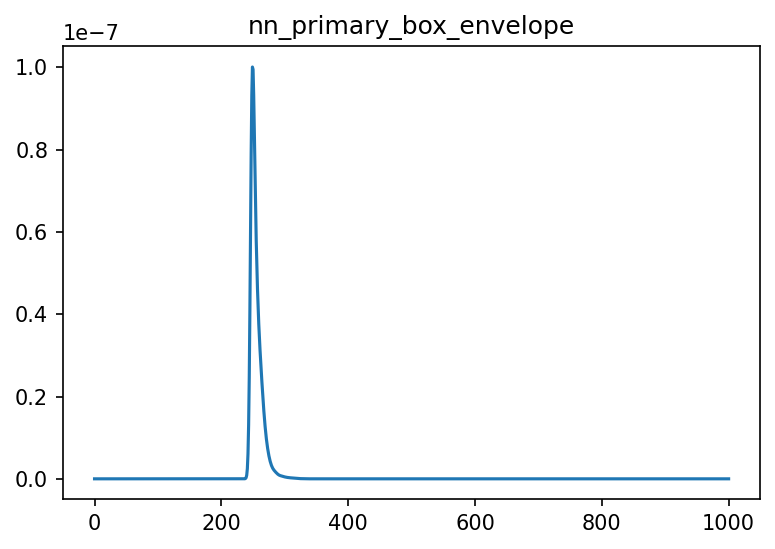

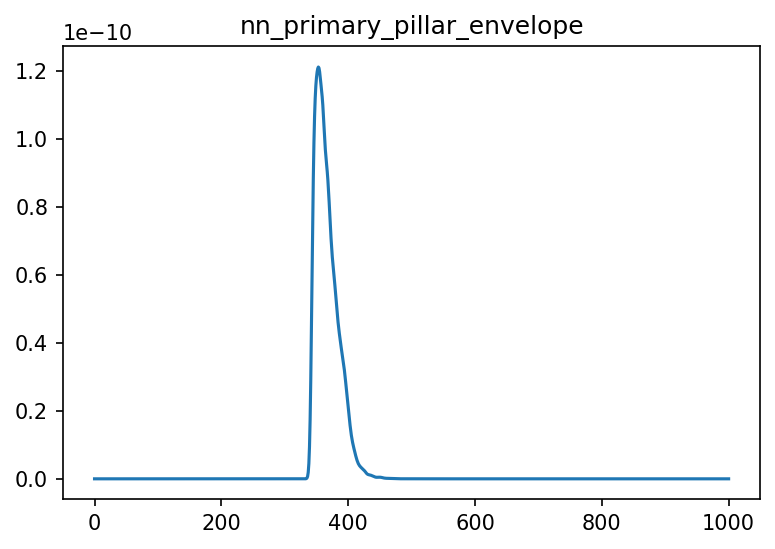

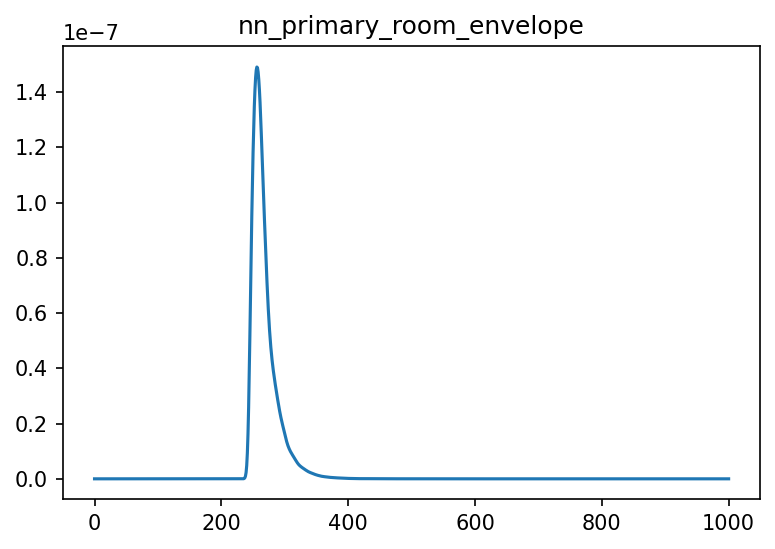

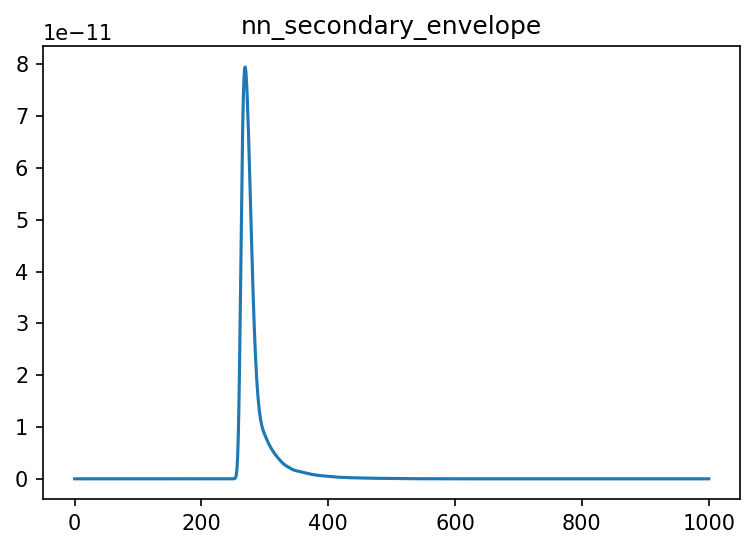

laser_norm_fac:  [1625287.53868608]


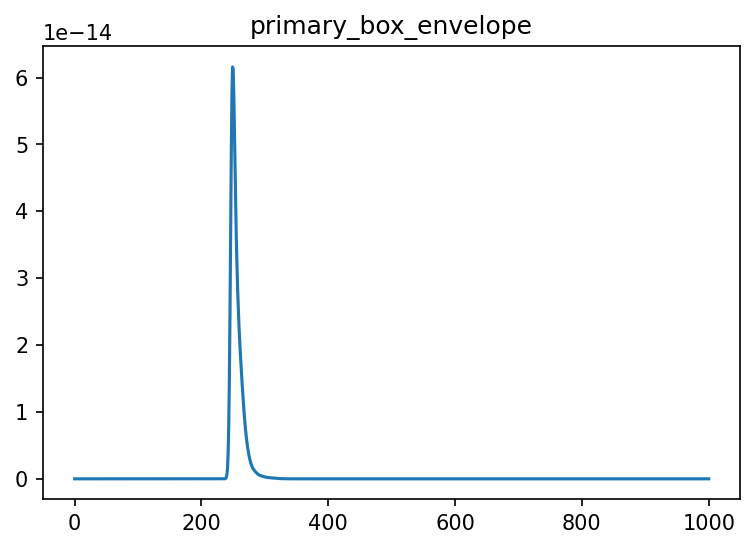

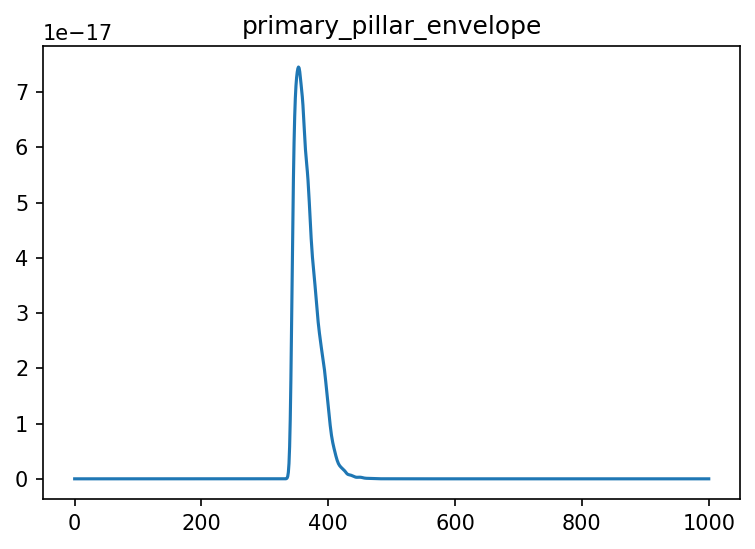

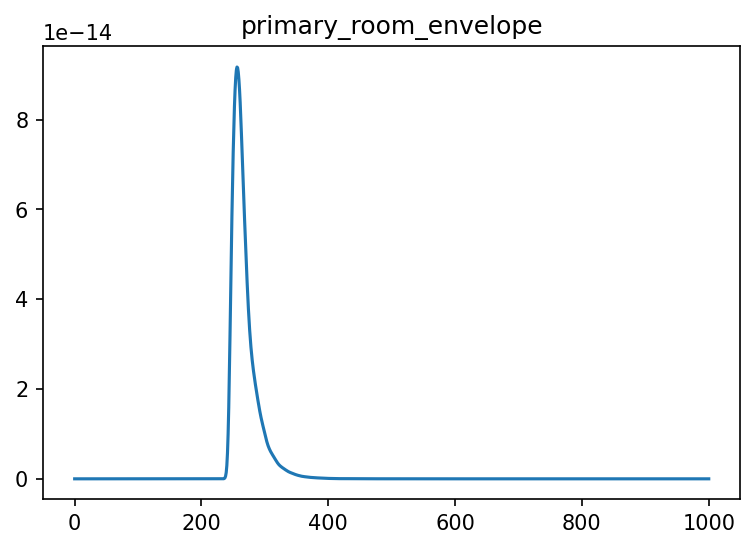

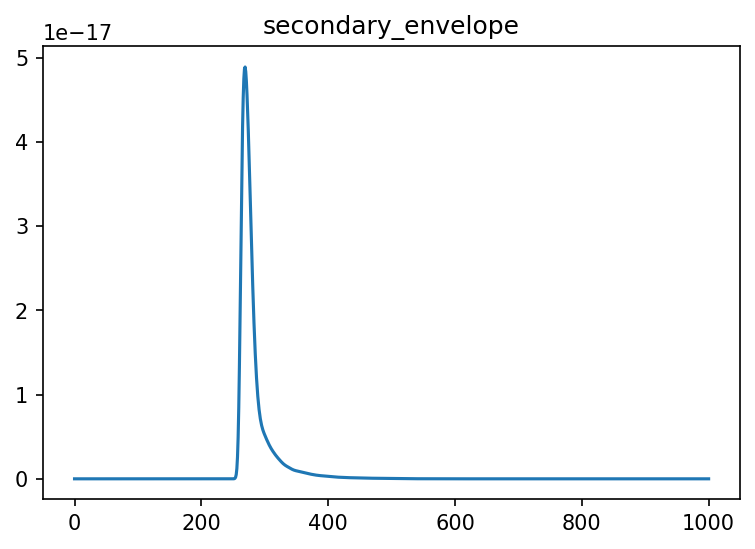

trapz_check:  3.6748985393520997e-22


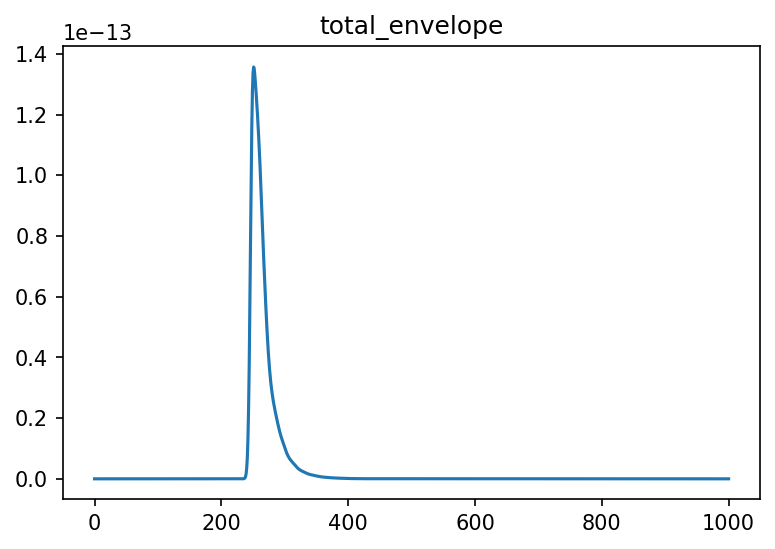

box pos:  249
pillar pos:  353
room pos:  256


NameError: name 'potatoe' is not defined

In [106]:
# All coordinates are in Unreal World space using a left handed coordinate system

lsr_emt_x = 0.0 #The x position of the laser source
lsr_emt_y = 0.0 #The y position of the laser source
lsr_emt_z = 1.0 #The z position of the laser source

spad_sen_x = 0.0 #The x position of the centre of the SPAD FoV
spad_sen_y = 0.0 #The y position of the centre of the SPAD FoV
spad_sen_z = 1.0 #The z position of the centre of the SPAD FoV

x_pnt_strt = 5.95 #The lower x bound of the SPAD FoV
x_pnt_end = 6.05 #The upper x bound of the SPAD FoV
y_pnt_strt = -1.0 #The lower y bound of the SPAD FoV
y_pnt_end = 1.0 #The upper y bound of the SPAD FoV
z_pnt_strt = 0.5 #The lower z bound of the SPAD FoV
z_pnt_end = 2.5 #The upper z bound of the SPAD FoV

pulse_width_fwhm = 600e-12#The pulse width of the laser

time_vec = np.linspace(0,100e-9,1001) #The time vector for plotting

num_cam_col_samples = 30#180#60#30#180 #The number of columns in each render target. This MUST be an even number
num_cam_row_samples = 30#180#60#30#180 #The number of rows in each render target. This MUST be an even number

arr_cols = int(num_cam_col_samples)
arr_rows = int(num_cam_col_samples)

#The lists below is known camera positions for the Test_2 dataset

#pillar laser side
idx_1 = 3
idx_2 = 7

#corner back wall
#idx_1 = 3
#idx_2 = 8

#left wall
#idx_1 = 2
#idx_2 = 2

#corner right wall
#idx_1 = 4
#idx_2 = 6

#floor
#idx_1 = 3
#idx_2 = 4

#roof
#idx_1 = 5
#idx_2 = 5

#

#idx_1 = 4
#idx_2 = 4

#sample_rays_num_1 = 10 #The number of rays sent out along one axis from the laser hit point for the Test_2 dataset
#sample_rays_num_2 = 10 #The number of rays sent out along the other axis from the laser hit point for the Test_2 dataset

sample_rays_num_1 = 45 #The number of rays sent out along the other axis from the laser hit point for the Test_3 dataset
sample_rays_num_2 = 45 #The number of rays sent out along the other axis from the laser hit point for the Test_3 dataset

cnt = 0 # A count variable to skip the first sample point which always seem to be glitched in Unreal

p_ang_in,t_ang_in,lsr_p_ang_out, lsr_t_ang_out, lsr_distces,lsr_hit_roll,lsr_hit_pitch,lsr_hit_yaw,lsr_for_x,lsr_for_y,lsr_for_z,lsr_z_pts,lsr_y_pts = get_laser_imgs(num_cam_row_samples,num_cam_col_samples,lsr_emt_x,lsr_emt_y,lsr_emt_z)#The data from the lookin spawned at the light source, this is used for shadow mapping.
#p_ang_in: The incident phi angle at the laser hit point for a laser coming in from the laser source
#t_ang_in: The incident theta angle at the laser hit point for a laser coming in from the laser source
#lsr_p_ang_out: The reflected phi angles at the laser hit point based on the lookin spawned there
#lsr_t_ang_out: The reflected theta angles at the laser hit point based on the lookin spawned there
#lsr_distces: The reflected distances at the laser hit point based on the lookin spawned there
#lsr_hit_roll: the roll in world angles used to create the lookin forward vector from the world forward vector
#lsr_hit_pitch: the pitch in world angles used to create the lookin forward vector from the world forward vector
#lsr_hit_yaw: the yaw in world angles used to create the lookin forward vector from the world forward vector
#lsr_for_x: the x component of the forward vector of the lookin
#lsr_for_y: the y component of the forward vector of the lookin
#lsr_for_z: the z component of the forward vector of the lookin
#lsr_z_pts: the vector of z values correspoding to the observed points of the lookin
#lsr_y_pts: the vector of y values correspoding to the observed points of the lookin


laser_norm_fac = 0.0# Initialize the laser normalization factor

for i in tqdm(range(0,sample_rays_num_1)):
    for j in range(0,sample_rays_num_2):

        idx_1 = i
        idx_2 = j

        #idx_1 = idx_1 #can be used to set maunal indexing for checking specific points
        #idx_2 = idx_2 #can be used to set maunal indexing for checking specific points


        #filename = "/home/sjs2001/Code/Unreal_Data_Processor/Seeing_Around_Corners/First_Test/Test_2/"+str(idx_1)+"_"+str(idx_2) #The filename of the Unreal data folder
        filename = "/home/sjs2001/Code/Unreal_Data_Processor/Seeing_Around_Corners/First_Test/Test_3/"+str(idx_1)+"_"+str(idx_2) #The filename of the Unreal data folder

        if os.path.isdir(filename) == True:# Checks if the folder exists

            ap_r_tmp,ap_g_tmp,ap_b_tmp = build_seg_cube_map(idx_1,idx_2)# all points red temporary, all points green temporary, all points blue temporary, these are vectors based on the segmentation render target used for identifying objects in the world.
            
            all_norm_x,all_norm_y,all_norm_z = build_normal_cube_map(idx_1,idx_2,ap_r_tmp,ap_b_tmp)# all points red temporary, all points green temporary, all points blue temporary, these are vectors based on the segmentation render target used for identifying objects in the world.
            
            lsr_x,lsr_y,lsr_z,hit_x,hit_y,hit_z,hit_for_x,hit_for_y,hit_for_z,hit_mat,hit_roll,hit_pitch,hit_yaw = read_hit_point_details(idx_1,idx_2)#The details from the text file for where each lookin spawns
            #lsr_x: the laser hit point in x
            #lsr_y: the laser hit point in y
            #lsr_z: the laser hit point in z
            #hit_x: the spawn point world x of the lookin
            #hit_y: the spawn point world y of the lookin
            #hit_z: the spawn point world z of the lookin
            #hit_for_x: the x component of the forward vector of the lookin
            #hit_for_y: the y component of the forward vector of the lookin
            #hit_for_z: the z component of the forward vector of the lookin
            #hit_mat: the material the lookin spawned on
            #hit_roll: the roll in world angles used to create the lookin forward vector from the world forward vector
            #hit_pitch: the pitch in world angles used to create the lookin forward vector from the world forward vector
            #hit_yaw: the yaw in world angles used to create the lookin forward vector from the world forward vector 

            x_tmp,y_tmp,z_tmp = get_wpts(idx_1,idx_2,ap_r_tmp,ap_b_tmp)#The vectors of the x,y, and z world points
            
            nx_tmp,ny_tmp,nz_tmp,x2_tmp,y2_tmp,z2_tmp,hit_mat_tmp,camera_distces_tmp,ray_distces_tmp,hit_pnt_phi_ang_out_tmp,hit_pnt_theta_ang_out_tmp,obs_hit_pnt_phi_ang_in_tmp,obs_hit_pnt_theta_ang_in_tmp,lsr_pnt_phi_ang_out_tmp,lsr_pnt_theta_ang_out_tmp,obs_lsr_pnt_phi_ang_in_tmp,obs_lsr_pnt_theta_ang_in_tmp,s_map_tmp,obj_map_tmp,lsr_hit_pnt_phi_angles_out_tmp,lsr_hit_pnt_theta_angles_out_tmp,lsr_hit_pnt_phi_angles_in_tmp,lsr_hit_pnt_theta_angles_in_tmp,lsr_obs_pnt_distces_tmp = calc_time_and_ang(num_cam_row_samples,num_cam_col_samples,x_tmp,y_tmp,z_tmp,lsr_x,lsr_y,lsr_z,hit_x,hit_y,hit_z,hit_for_x,hit_for_y,hit_for_z,hit_mat,hit_roll,hit_pitch,hit_yaw,lsr_z_pts,lsr_y_pts,lsr_p_ang_out, lsr_t_ang_out, lsr_distces,lsr_hit_roll,lsr_hit_pitch,lsr_hit_yaw,lsr_for_x,lsr_for_y,lsr_for_z,ap_r_tmp,ap_g_tmp,ap_b_tmp,all_norm_x,all_norm_y,all_norm_z)#calculates distances and angles associated with each lookin
            #nx_tmp: a vector corresponding to the x component of the forward vectors of the observed points as seen by the lookin point
            #ny_tmp: a vector corresponding to the y component of the forward vectors of the observed points as seen by the lookin point
            #nz_tmp: a vector corresponding to the z component of the forward vectors of the observed points as seen by the lookin point
            #x2_tmp: a vector corresponding to the x component of the position of the observed points as seen by the lookin point
            #y2_tmp: a vector corresponding to the y component of the position of the observed points as seen by the lookin point
            #z2_tmp: a vector corresponding to the z component of the position of the observed points as seen by the lookin point
            #hit_mat_tmp: a vector corresponding to the the material the lookin spawned on
            #camera_distces_tmp: a vector corresponding to the euclidean distance between the observed points and the lookin point
            #ray_distces_tmp: a vector corresponding to the euclidean distance between the laser hit point and the lookin point
            #hit_pnt_phi_ang_out_tmp: a vector corresponding to the phi reflection angles from the lookin point to each observed point
            #hit_pnt_theta_ang_out_tmp: a vector corresponding to the theta reflection angles from the lookin point to each observed point
            #obs_hit_pnt_phi_ang_in_tmp: a vector corresponding to the incident phi angle of each observed point from the associated lookin point
            #obs_hit_pnt_theta_ang_in_tmp: a vector corresponding to the incident theta angle of each observed point from the associated lookin point
            #lsr_pnt_phi_ang_out_tmp: a vector corresponding to the phi reflection angles from the laser hit point to each observed point
            #lsr_pnt_theta_ang_out_tmp: a vector corresponding to the theta reflection angles from the laser hit point to each observed point
            #obs_lsr_pnt_phi_ang_in_tmp: a vector corresponding to the incident phi angle of each observed point from the laser hit point
            #obs_lsr_pnt_theta_ang_in_tmp: a vector corresponding to the incident theta angle of each observed point from the laser hit point
            #s_map_tmp: a vector indicating whether a point is in shadow
            #obj_map_tmp: a vector derived from the segmentation vector, used to associate each observed point in a room with an object/brdf
            #lsr_hit_pnt_phi_angles_out_tmp: a vector corresponding to the phi reflection angles from the laser hit point to the lookin point
            #lsr_hit_pnt_theta_angles_out_tmp: a vector corresponding to the theta reflection angles from the laser hit point to the lookin point
            #lsr_hit_pnt_phi_angles_in_tmp: a vector corresponding to the phi incident angles from the laser hit point to the lookin point
            #lsr_hit_pnt_theta_angles_in_tmp: a vector corresponding to the theta incident angles from the laser hit point to the lookin point
            #lsr_obs_pnt_distces_tmp: a vector corresponding to the euclidean distances between the laser hit point and the observed points 

            local_lsr_sum_tmp,primary_lsr_brdf_vals_tmp,primary_brdf_vals_tmp,primary_path_losses_tmp,primary_path_length_tmp,secondary_lsr_brdf_vals_tmp,secondary_brdf_vals_tmp,secondary_path_losses_tmp,secondary_path_length_tmp = calc_brdfs(num_cam_row_samples,num_cam_col_samples,x2_tmp,y2_tmp,z2_tmp,s_map_tmp,hit_mat_tmp,lsr_pnt_phi_ang_out_tmp,hit_pnt_phi_ang_out_tmp,hit_pnt_theta_ang_out_tmp,lsr_hit_pnt_phi_angles_out_tmp,obs_hit_pnt_phi_ang_in_tmp,obs_hit_pnt_theta_ang_in_tmp,obj_map_tmp,ray_distces_tmp,camera_distces_tmp,lsr_obs_pnt_distces_tmp)#Calculates the brdf values and losses based on all the angles
            #local_lsr_sum_tmp: the sum of the laser hit point brdf values for the associated lookin
            #primary_lsr_brdf_vals_tmp: the brdf vals from the laser hit point to the lookin point
            #primary_brdf_vals_tmp: a vector of the brdfs vals from the lookin point to the observed points
            #primary_path_losses_tmp: a vector of the 1/r^2 losses from the lookin point to the observed points forming the primary paths
            #primary_path_length_tmp: a vector of the path lengths from the lookin point to the observed points forming the primary paths
            #secondary_lsr_brdf_vals_tmp: a vector of the brdf vals from the laser hit point to the observed points
            #secondary_brdf_vals_tmp: a vector of the brdfs vals from the lookin point to the observed points
            #secondary_path_losses_tmp: a vector of the 1/r^2 losses from the lookin point to the observed points forming the secondary paths
            #secondary_path_length_tmp: a vector of the path lengths from the lookin point to the observed points forming the secondary paths
            
            if cnt == 1:
                laser_norm_fac = laser_norm_fac+local_lsr_sum_tmp# a running total for the sum based normalization scheme

                fb_x,fb_y,fb_z,fb_primary_path_brdf,fb_primary_path_losses,fb_primary_path_len,fb_secondary_path_brdf,fb_secondary_path_losses,fb_secondary_path_len,fb_hit_mat_fov = calc_final_bounce(spad_sen_x,spad_sen_y,spad_sen_z,x_pnt_strt,x_pnt_end,y_pnt_strt,y_pnt_end,z_pnt_strt,z_pnt_end,nx_tmp,ny_tmp,nz_tmp,x2_tmp,y2_tmp,z2_tmp,s_map_tmp,hit_mat_tmp,primary_lsr_brdf_vals_tmp,primary_brdf_vals_tmp,primary_path_losses_tmp,primary_path_length_tmp,secondary_lsr_brdf_vals_tmp,secondary_brdf_vals_tmp,secondary_path_losses_tmp, secondary_path_length_tmp)#calculates the final bounce for the observed points which lie within the FoV of the SPAD
                #fb_x: a vector corresponding to the x coordinates of the points used in calculating the final bounce
                #fb_y: a vector corresponding to the y coordinates of the points used in calculating the final bounce
                #fb_z: a vector corresponding to the z coordinates of the points used in calculating the final bounce
                #fb_primary_path_brdf: a vector corresponding to the brdf values of the final bounce for the primary bounce paths
                #fb_primary_path_losses: a vector corresponding to the 1/r^2 losses of the final bounce for the primary bounce paths
                #fb_primary_path_len: a vector corresponding to the path length of the final bounce for the primary bounce paths
                #fb_secondary_path_brdf: a vector corresponding to the brdf values of the final bounce for the secondary bounce paths
                #fb_secondary_path_losses: a vector corresponding to the 1/r^2 losses of the final bounce for the secondary bounce paths
                #fb_secondary_path_len: a vector corresponding to the path length of the final bounce for the secondary bounce paths
                #fb_hit_mat_fov: a vector corresponding to the the material the lookin spawned on

                nn_primary_box_envelope_tmp,nn_primary_pillar_envelope_tmp,nn_primary_room_envelope_tmp,nn_secondary_envelope_tmp = make_non_norm_envelopes(pulse_width_fwhm,time_vec,fb_primary_path_len,fb_primary_path_losses,fb_primary_path_brdf,fb_secondary_path_len,fb_secondary_path_losses,fb_secondary_path_brdf,fb_hit_mat_fov)#Converts the paths to histogram envelopes based on the laser FWHM.

                nn_primary_box_envelope = np.copy(nn_primary_box_envelope_tmp) #The envelope associated with the primary bounces from the box
                nn_primary_pillar_envelope = np.copy(nn_primary_pillar_envelope_tmp) #The envelope associated with the primary bounces from the pillar
                nn_primary_room_envelope = np.copy(nn_primary_room_envelope_tmp) #The envelope associated with the primary bounces from everything else in the room

                nn_secondary_envelope = np.copy(nn_secondary_envelope_tmp) #The envelope associated with all the secondary bounces
                
            if cnt > 1:
                laser_norm_fac = laser_norm_fac+local_lsr_sum_tmp # a running total for the sum based normalization scheme
                
                fb_x,fb_y,fb_z,fb_primary_path_brdf,fb_primary_path_losses,fb_primary_path_len,fb_secondary_path_brdf,fb_secondary_path_losses,fb_secondary_path_len,fb_hit_mat_fov = calc_final_bounce(spad_sen_x,spad_sen_y,spad_sen_z,x_pnt_strt,x_pnt_end,y_pnt_strt,y_pnt_end,z_pnt_strt,z_pnt_end,nx_tmp,ny_tmp,nz_tmp,x2_tmp,y2_tmp,z2_tmp,s_map_tmp,hit_mat_tmp,primary_lsr_brdf_vals_tmp,primary_brdf_vals_tmp,primary_path_losses_tmp,primary_path_length_tmp,secondary_lsr_brdf_vals_tmp,secondary_brdf_vals_tmp,secondary_path_losses_tmp, secondary_path_length_tmp)
                #fb_x: a vector corresponding to the x coordinates of the points used in calculating the final bounce
                #fb_y: a vector corresponding to the y coordinates of the points used in calculating the final bounce
                #fb_z: a vector corresponding to the z coordinates of the points used in calculating the final bounce
                #fb_primary_path_brdf: a vector corresponding to the brdf values of the final bounce for the primary bounce paths
                #fb_primary_path_losses: a vector corresponding to the 1/r^2 losses of the final bounce for the primary bounce paths
                #fb_primary_path_len: a vector corresponding to the path length of the final bounce for the primary bounce paths
                #fb_secondary_path_brdf: a vector corresponding to the brdf values of the final bounce for the secondary bounce paths
                #fb_secondary_path_losses: a vector corresponding to the 1/r^2 losses of the final bounce for the secondary bounce paths
                #fb_secondary_path_len: a vector corresponding to the path length of the final bounce for the secondary bounce paths
                #fb_hit_mat_fov: a vector corresponding to the the material the lookin spawned on

                nn_primary_box_envelope_tmp,nn_primary_pillar_envelope_tmp,nn_primary_room_envelope_tmp,nn_secondary_envelope_tmp = make_non_norm_envelopes(pulse_width_fwhm,time_vec,fb_primary_path_len,fb_primary_path_losses,fb_primary_path_brdf,fb_secondary_path_len,fb_secondary_path_losses,fb_secondary_path_brdf,fb_hit_mat_fov)

                nn_primary_box_envelope = nn_primary_box_envelope+nn_primary_box_envelope_tmp #The envelope associated with the primary bounces from the box
                nn_primary_pillar_envelope = nn_primary_pillar_envelope+nn_primary_pillar_envelope_tmp #The envelope associated with the primary bounces from the pillar
                nn_primary_room_envelope = nn_primary_room_envelope+nn_primary_room_envelope_tmp #The envelope associated with the primary bounces from everything else in the room

                nn_secondary_envelope = nn_secondary_envelope+nn_secondary_envelope_tmp#The envelope associated with all the secondary bounces

        cnt = cnt+1


plt.plot(nn_primary_box_envelope)
plt.title("nn_primary_box_envelope")
plt.show()

plt.plot(nn_primary_pillar_envelope)
plt.title("nn_primary_pillar_envelope")
plt.show()

plt.plot(nn_primary_room_envelope)
plt.title("nn_primary_room_envelope")
plt.show()

plt.plot(nn_secondary_envelope)
plt.title("nn_secondary_envelope")
plt.show()

print("laser_norm_fac: ",laser_norm_fac)


plt.plot(nn_primary_box_envelope/laser_norm_fac)
plt.title("primary_box_envelope")
plt.show()

plt.plot(nn_primary_pillar_envelope/laser_norm_fac)
plt.title("primary_pillar_envelope")
plt.show()

plt.plot(nn_primary_room_envelope/laser_norm_fac)
plt.title("primary_room_envelope")
plt.show()

plt.plot(nn_secondary_envelope/laser_norm_fac)
plt.title("secondary_envelope")
plt.show()

total_envelope = (nn_primary_box_envelope/laser_norm_fac) + (nn_primary_pillar_envelope/laser_norm_fac) + (nn_primary_room_envelope/laser_norm_fac) + (nn_secondary_envelope/laser_norm_fac)

trapz_check = sp.integrate.trapz(total_envelope,time_vec)


print("trapz_check: ",trapz_check)

plt.plot(total_envelope)
plt.title("total_envelope")
plt.show()


print("box pos: ",np.argmax(nn_primary_box_envelope/laser_norm_fac))
print("pillar pos: ",np.argmax(nn_primary_pillar_envelope/laser_norm_fac))
print("room pos: ",np.argmax(nn_primary_room_envelope/laser_norm_fac))






In [107]:
#print("laser_norm_fac_45x45_60x60_multi_second_bounce:",laser_norm_fac)

#np.savetxt('S_A_C_Test_CSVs/nn_primary_box_envelope_45x45_60x60_multi_second_bounce.csv', np.squeeze(nn_primary_box_envelope) , delimiter=',')
#np.savetxt('S_A_C_Test_CSVs/nn_primary_pillar_envelope_45x45_60x60_multi_second_bounce.csv', np.squeeze(nn_primary_pillar_envelope) , delimiter=',')
#np.savetxt('S_A_C_Test_CSVs/nn_primary_room_envelope_45x45_60x60_multi_second_bounce.csv', np.squeeze(nn_primary_room_envelope) , delimiter=',')
#np.savetxt('S_A_C_Test_CSVs/nn_secondary_envelope_45x45_60x60_multi_second_bounce.csv', np.squeeze(nn_secondary_envelope) , delimiter=',')

#print("laser_norm_fac_45x45_30x30_multi_second_bounce:",laser_norm_fac)

#np.savetxt('S_A_C_Test_CSVs/nn_primary_box_envelope_10x10_60x60_multi_second_bounce.csv', np.squeeze(nn_primary_box_envelope) , delimiter=',')
#np.savetxt('S_A_C_Test_CSVs/nn_primary_pillar_envelope_10x10_60x60_multi_second_bounce.csv', np.squeeze(nn_primary_pillar_envelope) , delimiter=',')
#np.savetxt('S_A_C_Test_CSVs/nn_primary_room_envelope_10x10_60x60_multi_second_bounce.csv', np.squeeze(nn_primary_room_envelope) , delimiter=',')
#np.savetxt('S_A_C_Test_CSVs/nn_secondary_envelope_10x10_60x60_multi_second_bounce.csv', np.squeeze(nn_secondary_envelope) , delimiter=',')

laser_norm_fac_45x45_60x60_multi_second_bounce: [1625287.53868608]


In [105]:
def make_non_norm_envelopes(pulse_width_fwhm,time_vec,primary_path_len,primary_path_losses,primary_path_brdf,secondary_path_len,secondary_path_losses,secondary_path_brdf,hit_mat_fov):
    

    pulse_width = pulse_width_fwhm/(2.0*np.sqrt(2.0*np.log(2.0)))#The pulse width of the laser as a sigma value from the FWHM

    c_speed = 2.99e8#The speed of light

    aperture_radius_mm = 20#The radius of the collecting aperture in millimeters
    aperture_area = np.pi*((aperture_radius_mm)**2)#The area of the collecting aperture in square millimeters

    primary_arrival_time = primary_path_len/c_speed#The arrival time of the primary paths
    primary_arrival_amplitude = primary_path_losses*aperture_area*primary_path_brdf#The arrival amplitude of the primary paths made unitless

    primary_envelope_parts = primary_arrival_amplitude[...,np.newaxis]*(1.0/(pulse_width*np.sqrt(2.0*np.pi)))*np.exp(-0.5*(((time_vec-primary_arrival_time)/(pulse_width))**2))#Each primary path scaled by its arrival amplitude and centered around its arrival time

    primary_envelope = np.sum(primary_envelope_parts,axis=0)#summing the primary paths to give the primary arrival envelope
   
    secondary_arrival_amplitude = secondary_path_losses*aperture_area*secondary_path_brdf #The arrival amplitude of the secondary paths made unitless
    secondary_arrival_amplitude[secondary_arrival_amplitude<0.0] = 0.0#The arrival amplitude of the secondary paths checked for numerical errors
    
    secondary_arrival_time = secondary_path_len/c_speed#The arrival time of the secondary paths
    
    secondary_envelope_parts = secondary_arrival_amplitude[...,np.newaxis]*(1.0/(pulse_width*np.sqrt(2.0*np.pi)))*np.exp(-0.5*(((time_vec-secondary_arrival_time[...,np.newaxis])/(pulse_width))**2))#Each secondary path scaled by its arrival amplitude and centered around its arrival time

    secondary_envelope = np.sum(secondary_envelope_parts,axis=0)#summing the secondary paths to give the secondary arrival envelope
    
    primary_box_envelope = np.zeros((primary_envelope.shape))#Instantiating the box envelope variable
    primary_pillar_envelope = np.zeros((primary_envelope.shape))#Instantiating the pillar envelope variable
    primary_room_envelope = np.zeros((primary_envelope.shape))#Instantiating the everything else envelope variable

    if len(hit_mat_fov) > 0.0: #This assigns the primary envelopes to their corresponding sources based on the material on which the lookin spawned. This is not nessecary outside of being able to "split up" the final envelope into its pieces.

        if hit_mat_fov[0]=="Box":
            primary_box_envelope = primary_envelope

        if hit_mat_fov[0]=="Pillar":
            primary_pillar_envelope = primary_envelope

        if hit_mat_fov[0] != "Box" and hit_mat_fov[0] != "Pillar":
            primary_room_envelope = primary_envelope

    #return primary_envelope,secondary_envelope
    return primary_box_envelope,primary_pillar_envelope,primary_room_envelope,secondary_envelope



In [104]:
def calc_brdfs(n_c_r_s,n_c_c_s,xwpts, ywpts, zwpts,s_map,hit_mat,lsr_pnt_phi_ang_out,hit_pnt_phi_ang_out,hit_pnt_theta_ang_out,lsr_hit_pnt_phi_ang_out,obs_hit_pnt_phi_ang_in,obs_hit_pnt_theta_ang_in,seg_r,ray_dist,cam_dist,lsr_obs_pnt_distces):
    
    sec_scatter_idxs = np.all(np.column_stack((np.squeeze(s_map)>0.0,hit_mat != "SPAD_Direction")),axis=1)#The indices of illuminated points from lookins which are not going down the corridor.

    sec_seg_r = seg_r[seg_r>0.0]#The a vector based on the red channel of the segmentation vector only for points within the room. 

    pillar_sec_idxs = np.all(np.column_stack((np.squeeze(sec_seg_r)==2.0,np.squeeze(s_map)>0.0,hit_mat != "SPAD_Direction")),axis=1)#The indices of illuminated points from lookins which are not going down the corridor and which are on the pillar.

    lsr_scattering_brdf = np.squeeze(np.zeros((len(lsr_pnt_phi_ang_out),1)))
    lsr_scattering_brdf[sec_scatter_idxs] = np.cos(np.squeeze(lsr_pnt_phi_ang_out[sec_scatter_idxs]))#The laser hit point scattering to all illuminated observed points assumed to have Lambertian scattering and not normalised because it uses the sum based normalization at the end.


    obs_scattering_brdf_second = np.squeeze(np.zeros((len(lsr_pnt_phi_ang_out),1)))
    obs_scattering_brdf_second[sec_scatter_idxs] = np.cos(np.squeeze(obs_hit_pnt_phi_ang_in[sec_scatter_idxs]))/np.pi#Lambertian scattering for oberserved points used for secondary paths, normalised using the integral scheme
    obs_scattering_brdf_second[pillar_sec_idxs] = np.abs(np.sin(obs_hit_pnt_theta_ang_in[pillar_sec_idxs]))/(4.0)#made up Sin scattering for oberserved points on the pillar used for secondary paths, normalised using the integral scheme
    #Note that the secondary scatters are using the incident angles for the observed points. This is because the angles are reciprical, i.e., the reflection angle From the observed point To the lookin point, is the same as the incident angle, From the lookin
    #To the observed point.

    #####################################################################################################################################################################################################
    #####################################################################################################################################################################################################

    
    #seg codes
    #1 = wall
    #2 = pillar
    #3 = box
    #4 = SPAD_FoV wall
    #5 = SPAD direction wall

    lsr_to_hit_scattering_brdf = np.cos(lsr_hit_pnt_phi_ang_out)#The Lambertian scattering of the laser hit point, to the lookin point. Not normalised because it uses the sum based normalization at the end.
    
    hit_scattering_brdf = np.float32(np.cos(hit_pnt_phi_ang_out))#The Lambertian scattering of the lookin points. Not normalised because it uses the sum based normalization at the end.

    hit_scattering_brdf[hit_mat == "Pillar"] = np.abs(np.sin(hit_pnt_theta_ang_out[hit_mat == "Pillar"]))#made up Sin scattering for lookin points on the pillar. Not normalised because it uses the sum based normalization at the end.

    hit_scattering_brdf = hit_scattering_brdf/np.sum(hit_scattering_brdf)#The brdf for the lookin point normalised using the summation normalizaiton scheme.

    hit_second_scattering = np.matmul(hit_scattering_brdf,np.transpose(obs_scattering_brdf_second[...,np.newaxis]))#Matrix multiplication so that each BRDF reflection value from the lookin is multiplied by all secondary scatters from observed points

    ray_loss = (1.0/((ray_dist/1.0e-3)**2))#The 1/r^2 losses, calculated in millimeters for the distance between the laser hit point and the lookin point.

    cam_dist_loss = 1.0/((cam_dist/1.0e-3)**2)#The 1/r^2 losses, calculated in millimeters for the distance between the lookin points and the observed points.
    lsr_obs_pnt_distces_loss = 1.0/((lsr_obs_pnt_distces/1.0e-3)**2)#The 1/r^2 losses, calculated in millimeters for the distance between the laser hit point and the observed points.

    hit_second_paths = cam_dist_loss*lsr_obs_pnt_distces_loss#The 1/r^2 losses for the secondary paths, from the laser to the observed points, then to the lookin point.

    hit_second_lengths = cam_dist+lsr_obs_pnt_distces#The euclidean distance from the laser hit point to the observed points then to the lookin point.
    
    primary_lsr_brdf_vals = lsr_to_hit_scattering_brdf#The laser to lookin brdf values for the primary paths
    primary_brdf_vals = hit_scattering_brdf#The lookin to observed points brdf values for the primary paths
    primary_path_losses = ray_loss*cam_dist_loss#The 1/r^2 losses based on the euclidean distance from the laser to the lookin point and then to the observed points for the primary paths
    primary_path_length = ray_dist+cam_dist#The path length based on the euclidean distance from the laser to the lookin point and then to the observed points for the primary paths

    secondary_lsr_brdf_vals = lsr_scattering_brdf#The laser to observed point brdf values for the secondary paths
    secondary_brdf_vals = hit_second_scattering#The lookin to observed points brdf values for the secondary paths
    secondary_path_losses = np.matmul(cam_dist_loss,np.transpose(hit_second_paths))#The 1/r^2 losses based on the euclidean distance from the lookin to the observed points. For each reflection path, all incident paths must be considered hence the matrix multiplication
    secondary_path_length = cam_dist+np.transpose(hit_second_lengths)#The path length based on the euclidean distance from the lookin to the observed points. For each reflection path, all incident paths must be considered hence the matrix multiplication

    local_lsr_sum = lsr_to_hit_scattering_brdf[0]+np.sum(lsr_scattering_brdf)#The local sum of the laser brdf for use in the later summation normlaization of the laser brdf.

    return local_lsr_sum,primary_lsr_brdf_vals,primary_brdf_vals,primary_path_losses,primary_path_length,secondary_lsr_brdf_vals,secondary_brdf_vals,secondary_path_losses,secondary_path_length




In [103]:
def calc_final_bounce(spad_sen_x,spad_sen_y,spad_sen_z,x_pnt_strt,x_pnt_end,y_pnt_strt,y_pnt_end,z_pnt_strt,z_pnt_end,n_x,n_y,n_z,xwpts,ywpts,zwpts,s_map,hit_mat,primary_lsr_brdf_vals,primary_brdf_vals,primary_path_losses,primary_path_length,secondary_lsr_brdf_vals,secondary_brdf_vals,secondary_path_losses, secondary_path_length):

    spad_fov_idxs = np.all(np.column_stack((xwpts>x_pnt_strt,xwpts<x_pnt_end,ywpts>y_pnt_strt,ywpts<y_pnt_end,zwpts>z_pnt_strt,zwpts<z_pnt_end,hit_mat != "SPAD_Direction")),axis=1)#An index list for all the observed points which lie within the FoV of the SPAD but which do not come from lookins located down the corridor.

    pts_x = np.squeeze(xwpts[spad_fov_idxs])#The x values of the observed points within the FoV
    pts_y = np.squeeze(ywpts[spad_fov_idxs])#The y values of the observed points within the FoV
    pts_z = np.squeeze(zwpts[spad_fov_idxs])#The z values of the observed points within the FoV

    n_x_fov = np.squeeze(n_x[spad_fov_idxs])#The x component of the forward vector of observed points within the FoV
    n_y_fov = np.squeeze(n_y[spad_fov_idxs])#The y component of the forward vector of observed points within the FoV
    n_z_fov = np.squeeze(n_z[spad_fov_idxs])#The z component of the forward vector of observed points within the FoV

    s_map_fov = np.squeeze(s_map[spad_fov_idxs])#The shadow map of observed points within the FoV
    hit_mat_fov = np.squeeze(hit_mat[spad_fov_idxs])#The hit mat of observed points within the FoV

    primary_brdf_vals_fov = np.squeeze(primary_brdf_vals[spad_fov_idxs]*(primary_lsr_brdf_vals[spad_fov_idxs]))#The primary path brdf values for points within the FoV based on the product of the laser to the lookin point and the lookin point to the observed points
    primary_path_losses_fov = np.squeeze(primary_path_losses[spad_fov_idxs])#The primary path 1/r^2 losses for points within the FoV based on the product of the laser to the lookin point and the lookin point to the observed points
    primary_path_length_fov = primary_path_length[spad_fov_idxs]#The primary path length for points within the FoV based on the product of the laser to the lookin point and the lookin point to the observed points

    #####################################################################################################################################################################################################
    #####################################################################################################################################################################################################

    pnt_pitch = np.squeeze(np.arcsin(n_z_fov))#The pitch in world angles used to create the observed points forward vector from the world forward vector
    pnt_yaw = np.squeeze(np.arctan2(n_y_fov,n_x_fov))#The yaw in world angles used to create the observed points forward vector from the world forward vector
    pnt_roll = np.squeeze(np.squeeze(np.zeros((len(pnt_pitch),1))))#The roll in world angles used to create the observed points forward vector from the world forward vector

    pnt_yaw[pnt_pitch >= np.pi/2.0] = np.pi#This is to account for how unreal treats angles which are greater than pi/2
    pnt_roll[pnt_pitch >= np.pi/2.0] = np.pi#This is to account for how unreal treats angles which are greater than pi/2
    pnt_yaw[pnt_pitch <= -np.pi/2.0] = np.pi#This is to account for how unreal treats angles which are greater than pi/2
    pnt_roll[pnt_pitch <= -np.pi/2.0] = np.pi#This is to account for how unreal treats angles which are greater than pi/2

    lcl_angs = np.column_stack((pnt_pitch,pnt_yaw,pnt_roll))#A stack of local angles

    r = Rot.from_euler('yzx',lcl_angs, degrees=False)
    r1 = r.inv()
    r2 = r1.as_matrix()#Calculating the inverse rotation matrix

    obs_spad_pnt_distces_out = np.sqrt((pts_x-spad_sen_x)**2 +(pts_y-spad_sen_y)**2 +(pts_z-spad_sen_z)**2)#The Euclidean distance from the observed points to the SPAD sensor
    obs_spad_pnt_phi_angles_out = np.arccos(-1.0*(((pts_x-spad_sen_x)*n_x_fov)+((pts_y-spad_sen_y)*n_y_fov)+((pts_z-spad_sen_z)*n_z_fov))/(obs_spad_pnt_distces_out))#The Phi reflection angles from the observed points to the SPAD sensor

    local_x = r2[:,0,0]*spad_sen_x + r2[:,0,1]*spad_sen_y+ r2[:,0,2]*spad_sen_z#The x component of the SPAD sensor rotated to the coordinate system of the points within the FoV
    local_y = r2[:,1,0]*spad_sen_x + r2[:,1,1]*spad_sen_y + r2[:,1,2]*spad_sen_z#The y component of the SPAD sensor rotated to the coordinate system of the points within the FoV
    local_z = r2[:,2,0]*spad_sen_x + r2[:,2,1]*spad_sen_y+ r2[:,2,2]*spad_sen_z#The z component of the SPAD sensor rotated to the coordinate system of the points within the FoV

    l_h_x = r2[:,0,0]*np.squeeze(pts_x) + r2[:,0,1]*np.squeeze(pts_y) + r2[:,0,2]*np.squeeze(pts_z)#The x component of the observed points rotated to the coordinate system of the points within the FoV
    l_h_y = r2[:,1,0]*np.squeeze(pts_x) + r2[:,1,1]*np.squeeze(pts_y) + r2[:,1,2]*np.squeeze(pts_z)#The y component of the observed points rotated to the coordinate system of the points within the FoV
    l_h_z = r2[:,2,0]*np.squeeze(pts_x) + r2[:,2,1]*np.squeeze(pts_y) + r2[:,2,2]*np.squeeze(pts_z)#The z component of the observed points rotated to the coordinate system of the points within the FoV

    x_lcl = local_x - l_h_x#The x component of the observed points in local coordinates
    y_lcl = local_y - l_h_y#The y component of the observed points in local coordinates
    z_lcl = local_z - l_h_z#The z component of the observed points in local coordinates

    obs_spad_pnt_theta_angles_out = np.arctan2(y_lcl,z_lcl)+np.pi#The Theta reflection angles from the observed points to the SPAD sensor

    #################################################################################################################################################################################################
    #################################################################################################################################################################################################


    #seg codes
    #1 = wall
    #2 = pillar
    #3 = box
    #4 = SPAD_FoV wall
    #5 = SPAD direction wall

    final_bounce_lambertian = np.squeeze(np.zeros((len(obs_spad_pnt_phi_angles_out),1)))#The brdf of the final bounce assumed to be Lambertian
    final_bounce_lambertian = np.cos(obs_spad_pnt_phi_angles_out)/np.pi#The brdf of the final bounce assumed to be Lambertian. Normalised using the integral normalisation scheme.

    final_bounce_losses = (1.0/((obs_spad_pnt_distces_out/1.0e-3)**2))#The 1/r^2 losses, calculated in millimeters for the distance between the observed points and the SPAD sensor.

    primary_path_brdf = final_bounce_lambertian*primary_brdf_vals_fov#The final brdf for primary paths. 
    primary_path_losses = final_bounce_losses*primary_path_losses_fov#The final 1/r^2 losses for primary paths.
    primary_path_len = primary_path_length_fov+obs_spad_pnt_distces_out[:,np.newaxis]#The final path lengths for primary paths.

    sum_tmp = 0#A temporary sum

    slbv = np.matlib.repmat(secondary_lsr_brdf_vals,secondary_brdf_vals.shape[0],1)#Secondary laser brdf values. The brdf from the laser to the observed points kept as a column vector, but copied into multiple rows to create a 2D matrix.
    slbvarr_0 = slbv*secondary_brdf_vals#The product of the Secondary laser brdf values with the 2D matrix of scondary brdf values from the lookin points.
    slbvarr = np.copy(slbvarr_0[spad_fov_idxs])#Reducing the seconadry path brdf values to only those which land within the FoV of the SPAD.

    splarr = secondary_path_losses[spad_fov_idxs]#Reducing the seconadry path 1/r^2 losses to only those which land within the FoV of the SPAD.

    splenarr = secondary_path_length[spad_fov_idxs]#Reducing the seconadry path lengths to only those which land within the FoV of the SPAD.
    
    fbl = final_bounce_lambertian[...,np.newaxis]*slbvarr#Applying the final bounce brdf to each row of the 2D secondary brdf matrix.
    fbl_2 = np.squeeze(np.reshape(fbl,(-1,1)))#Reshaping the 2D brdf matrix to a 1D vector
    secondary_path_brdf = fbl_2

    fbls = final_bounce_losses[...,np.newaxis]*splarr#Applying the final bounce 1/r^2 losses to each row of the 2D secondary 1/r^2 losses matrix.
    fbls_2 = np.squeeze(np.reshape(fbls,(-1,1)))#Reshaping the 2D 1/r^2 losses matrix to a 1D vector
    secondary_path_loss = fbls_2

    fblen = obs_spad_pnt_distces_out[...,np.newaxis]+splenarr#Applying the final bounce path length to each row of the 2D secondary path length matrix.
    fblen_2 = np.squeeze(np.reshape(fblen,(-1,1)))#Reshaping the 2D path length matrix to a 1D vector
    secondary_path_len = fblen_2

    sum_tmp = sum_tmp + np.sum(fbl)#A temporary sum
    
    return pts_x,pts_y,pts_z,primary_path_brdf,primary_path_losses,primary_path_len,secondary_path_brdf,secondary_path_loss,secondary_path_len,hit_mat_fov

In [102]:
def get_wpts(idx_1,idx_2,seg_r,seg_b):

    #Due to cv2 the render targets are imported in BGR rather than RGB

    #filename = "/home/sjs2001/Code/Unreal_Data_Processor/Seeing_Around_Corners/First_Test/Test_2/"+str(idx_1)+"_"+str(idx_2)+"/PNTS_F.EXR"
    filename = "/home/sjs2001/Code/Unreal_Data_Processor/Seeing_Around_Corners/First_Test/Test_3/"+str(idx_1)+"_"+str(idx_2)+"/PNTS_F.EXR"#The filepath to the forward world points render target
    wpts_f = cv2.imread(filename,cv2.IMREAD_UNCHANGED)[:,:,0:3]/100.0#The x,y,z values converted to metres. The UNCHANGED flag ensures the data is not normalised during read in

    lmr,lmc = wpts_f[:,:,0].shape#The number of rows and columns in one render target
    #print("lmr ",lmr)

    lmr = int(lmr/2)#The middel row of the render target, this is why the render target need to be even numbers
    lmc = int(lmc/2)#The middel column of the render target, this is why the render target need to be even numbers

    #filename = "/home/sjs2001/Code/Unreal_Data_Processor/Seeing_Around_Corners/First_Test/Test_2/"+str(idx_1)+"_"+str(idx_2)+"/PNTS_D.EXR"#The filepath to the downward world points render target
    filename = "/home/sjs2001/Code/Unreal_Data_Processor/Seeing_Around_Corners/First_Test/Test_3/"+str(idx_1)+"_"+str(idx_2)+"/PNTS_D.EXR"
    wpts_d = cv2.imread(filename,cv2.IMREAD_UNCHANGED)[0:lmr,:,0:3]/100.0#The x,y,z values converted to metres. Only half the render target is used to preserve the 180 degree FoV. The UNCHANGED flag ensures the data is not normalised during read in
    #filename = "/home/sjs2001/Code/Unreal_Data_Processor/Seeing_Around_Corners/First_Test/Test_2/"+str(idx_1)+"_"+str(idx_2)+"/PNTS_U.EXR"#The filepath to the upward world points render target
    filename = "/home/sjs2001/Code/Unreal_Data_Processor/Seeing_Around_Corners/First_Test/Test_3/"+str(idx_1)+"_"+str(idx_2)+"/PNTS_U.EXR"
    wpts_u = cv2.imread(filename,cv2.IMREAD_UNCHANGED)[lmr:,:,0:3]/100.0#The x,y,z values converted to metres. Only half the render target is used to preserve the 180 degree FoV. The UNCHANGED flag ensures the data is not normalised during read in
    #filename = "/home/sjs2001/Code/Unreal_Data_Processor/Seeing_Around_Corners/First_Test/Test_2/"+str(idx_1)+"_"+str(idx_2)+"/PNTS_L.EXR"#The filepath to the leftward world points render target
    filename = "/home/sjs2001/Code/Unreal_Data_Processor/Seeing_Around_Corners/First_Test/Test_3/"+str(idx_1)+"_"+str(idx_2)+"/PNTS_L.EXR"
    wpts_l = cv2.imread(filename,cv2.IMREAD_UNCHANGED)[:,lmc:,0:3]/100.0#The x,y,z values converted to metres. Only half the render target is used to preserve the 180 degree FoV. The UNCHANGED flag ensures the data is not normalised during read in
    #filename = "/home/sjs2001/Code/Unreal_Data_Processor/Seeing_Around_Corners/First_Test/Test_2/"+str(idx_1)+"_"+str(idx_2)+"/PNTS_R.EXR"#The filepath to the rightward world points render target
    filename = "/home/sjs2001/Code/Unreal_Data_Processor/Seeing_Around_Corners/First_Test/Test_3/"+str(idx_1)+"_"+str(idx_2)+"/PNTS_R.EXR"
    wpts_r = cv2.imread(filename,cv2.IMREAD_UNCHANGED)[:,0:lmc,0:3]/100.0#The x,y,z values converted to metres. Only half the render target is used to preserve the 180 degree FoV. The UNCHANGED flag ensures the data is not normalised during read in

    world_pts_x_f = np.reshape(wpts_f[:,:,2],(-1,1))#reshaping the forward render target x values to a vector 
    world_pts_y_f = np.reshape(wpts_f[:,:,1],(-1,1))#reshaping the forward render target y values to a vector 
    world_pts_z_f = np.reshape(wpts_f[:,:,0],(-1,1))#reshaping the forward render target z values to a vector 

    world_pts_x_d = np.reshape(wpts_d[:,:,2],(-1,1))#reshaping the downward render target x values to a vector 
    world_pts_y_d = np.reshape(wpts_d[:,:,1],(-1,1))#reshaping the downward render target y values to a vector 
    world_pts_z_d = np.reshape(wpts_d[:,:,0],(-1,1))#reshaping the downward render target z values to a vector 

    world_pts_x_u = np.reshape(wpts_u[:,:,2],(-1,1))#reshaping the upward render target x values to a vector 
    world_pts_y_u = np.reshape(wpts_u[:,:,1],(-1,1))#reshaping the upward render target y values to a vector 
    world_pts_z_u = np.reshape(wpts_u[:,:,0],(-1,1))#reshaping the upward render target z values to a vector 

    world_pts_x_l = np.reshape(wpts_l[:,:,2],(-1,1))#reshaping the leftward render target x values to a vector 
    world_pts_y_l = np.reshape(wpts_l[:,:,1],(-1,1))#reshaping the leftward render target y values to a vector 
    world_pts_z_l = np.reshape(wpts_l[:,:,0],(-1,1))#reshaping the leftward render target z values to a vector 

    world_pts_x_r = np.reshape(wpts_r[:,:,2],(-1,1))#reshaping the rightward render target x values to a vector 
    world_pts_y_r = np.reshape(wpts_r[:,:,1],(-1,1))#reshaping the rightward render target y values to a vector 
    world_pts_z_r = np.reshape(wpts_r[:,:,0],(-1,1))#reshaping the rightward render target z values to a vector 

    all_pts_x = np.vstack((world_pts_x_f,world_pts_x_d,world_pts_x_u,world_pts_x_l,world_pts_x_r))#stacking the x values of all world points into a single vector.

    all_pts_y = np.vstack((world_pts_y_f,world_pts_y_d,world_pts_y_u,world_pts_y_l,world_pts_y_r))#stacking the y values of all world points into a single vector.

    all_pts_z = np.vstack((world_pts_z_f,world_pts_z_d,world_pts_z_u,world_pts_z_l,world_pts_z_r))#stacking the z values of all world points into a single vector.

    in_room = seg_r+seg_b#combining the blue and red channels for segmentation.

    return all_pts_x,all_pts_y,all_pts_z

In [100]:
def calc_time_and_ang(sr,sc,pts_x,pts_y,pts_z,lsr_x,lsr_y,lsr_z,hit_x,hit_y,hit_z,hit_for_x,hit_for_y,hit_for_z,hit_mat,hit_roll,hit_pitch,hit_yaw,lsr_z_pts,lsr_y_pts,lsr_p_ang_out, lsr_t_ang_out, lsr_distces,lsr_hit_roll,lsr_hit_pitch,lsr_hit_yaw,lsr_for_x,lsr_for_y,lsr_for_z,seg_vec_r,seg_vec_g,seg_vec_b,n_x,n_y,n_z):
    
    in_room = np.squeeze(seg_vec_r)#The red channel of the segmentation vector. For identifing points within the room.

    hit_pnt_distces = np.sqrt((pts_x-hit_x)**2 +(pts_y-hit_y)**2 +(pts_z-hit_z)**2)#The Euclidean distance between the observed points and the lookin
    hit_pnt_phi_angles_out = np.arccos((((pts_x-hit_x)*hit_for_x)+((pts_y-hit_y)*hit_for_y)+((pts_z-hit_z)*hit_for_z))/(hit_pnt_distces))#The Phi reflection angles from the lookin to the observed points

    r = Rot.from_euler('yzx',[hit_pitch, hit_yaw, hit_roll], degrees=True)
    r1 = r.inv()
    r2 = r1.as_matrix()#The rotation matrix to move the world points into the local coordinate system of the lookin point.

    local_x = r2[0,0]*pts_x + r2[0,1]*pts_y + r2[0,2]*pts_z#The x values of the observed points rotated to the local coords system of the lookin point
    local_y = r2[1,0]*pts_x + r2[1,1]*pts_y + r2[1,2]*pts_z#The y values of the observed points rotated to the local coords system of the lookin point
    local_z = r2[2,0]*pts_x + r2[2,1]*pts_y + r2[2,2]*pts_z#The z values of the observed points rotated to the local coords system of the lookin point

    l_h_x = r2[0,0]*hit_x + r2[0,1]*hit_y + r2[0,2]*hit_z#The x value of the lookin point rotated to the local coords system of the lookin point
    l_h_y = r2[1,0]*hit_x + r2[1,1]*hit_y + r2[1,2]*hit_z#The y value of the lookin point rotated to the local coords system of the lookin point
    l_h_z = r2[2,0]*hit_x + r2[2,1]*hit_y + r2[2,2]*hit_z#The z value of the lookin point rotated to the local coords system of the lookin point

    x_lcl = local_x - l_h_x#The x values of the observed points in the local coords system of the lookin point
    y_lcl = local_y - l_h_y#The y values of the observed points in the local coords system of the lookin point
    z_lcl = local_z - l_h_z#The z values of the observed points in the local coords system of the lookin point

    hit_pnt_theta_angles_out = np.arctan2(y_lcl,z_lcl)+np.pi#The Theta reflection values from the lookin to the observed points. The +pi is so that the range in 0,2pi rather than -pi,pi.

    ####################################################################################################################################################################################################
    ####################################################################################################################################################################################################

    
    pnt_pitch = np.squeeze(np.arcsin(n_z))#The pitch in world angles used to create the observed points forward vector from the world forward vector
    pnt_yaw = np.squeeze(np.arctan2(n_y,n_x))#The yaw in world angles used to create the observed points forward vector from the world forward vector
    pnt_roll = np.squeeze(np.squeeze(np.zeros((len(pnt_pitch),1))))#The roll in world angles used to create the observed points forward vector from the world forward vector

    pnt_yaw[pnt_pitch >= np.pi/2.0] = np.pi#This is to account for how unreal treats angles which are greater than pi/2
    pnt_roll[pnt_pitch >= np.pi/2.0] = np.pi#This is to account for how unreal treats angles which are greater than pi/2
    pnt_yaw[pnt_pitch <= -np.pi/2.0] = np.pi#This is to account for how unreal treats angles which are greater than pi/2
    pnt_roll[pnt_pitch <= -np.pi/2.0] = np.pi#This is to account for how unreal treats angles which are greater than pi/2

    lcl_angs = np.column_stack((pnt_pitch,pnt_yaw,pnt_roll))#A stack of local angles

    r = Rot.from_euler('yzx',lcl_angs, degrees=False)
    r1 = r.inv()
    r2 = r1.as_matrix()#Calculating the inverse rotation matrix

    obs_hit_pnt_distces_in = np.sqrt((pts_x-hit_x)**2 +(pts_y-hit_y)**2 +(pts_z-hit_z)**2)#The Euclidean distance between the observed points and the lookin
    obs_hit_pnt_phi_angles_in = np.arccos(-1.0*(((pts_x-hit_x)*n_x)+((pts_y-hit_y)*n_y)+((pts_z-hit_z)*n_z))/(obs_hit_pnt_distces_in))#The Phi incident angles of the observed points from the lookin point
    
    local_x = r2[:,0,0]*hit_x + r2[:,0,1]*hit_y + r2[:,0,2]*hit_z#The x values of the lookin point rotated to the local coords system of each observed point
    local_y = r2[:,1,0]*hit_x + r2[:,1,1]*hit_y + r2[:,1,2]*hit_z#The y values of the lookin point rotated to the local coords system of each observed point
    local_z = r2[:,2,0]*hit_x + r2[:,2,1]*hit_y + r2[:,2,2]*hit_z#The z values of the lookin point rotated to the local coords system of each observed point

    l_h_x = r2[:,0,0]*np.squeeze(pts_x) + r2[:,0,1]*np.squeeze(pts_y) + r2[:,0,2]*np.squeeze(pts_z)#The x value of the observed points rotated to the local coords system of each observed point
    l_h_y = r2[:,1,0]*np.squeeze(pts_x) + r2[:,1,1]*np.squeeze(pts_y) + r2[:,1,2]*np.squeeze(pts_z)#The y value of the observed points rotated to the local coords system of each observed point
    l_h_z = r2[:,2,0]*np.squeeze(pts_x) + r2[:,2,1]*np.squeeze(pts_y) + r2[:,2,2]*np.squeeze(pts_z)#The z value of the observed points rotated to the local coords system of each observed point

    x_lcl = local_x - l_h_x#The x values of the lookin point in the local coords system of each observed point
    y_lcl = local_y - l_h_y#The y values of the lookin point in the local coords system of each observed point
    z_lcl = local_z - l_h_z#The z values of the lookin point in the local coords system of each observed point

    obs_hit_pnt_theta_angles_in = np.arctan2(y_lcl,z_lcl)+np.pi#The Theta incident angles of the observed points from the lookin point. The +pi is so that the range in 0,2pi rather than -pi,pi.
    
    #####################################################################################################################################################################################################
    #####################################################################################################################################################################################################

    lsr_obs_pnt_distces = np.sqrt((pts_x-lsr_x)**2 +(pts_y-lsr_y)**2 +(pts_z-lsr_z)**2)#The Euclidean distance between the laser hit point and the observed points
    lsr_obs_pnt_phi_angles_out = np.arccos((((pts_x-lsr_x)*lsr_for_x)+((pts_y-lsr_y)*lsr_for_y)+((pts_z-lsr_z)*lsr_for_z))/(lsr_obs_pnt_distces))#The Phi reflection angles from the laser hit point to the observed points

    r = Rot.from_euler('yzx',[lsr_hit_pitch, lsr_hit_yaw, lsr_hit_roll], degrees=True)
    r1 = r.inv()
    r2 = r1.as_matrix()#The rotation matrix to move the world points into the local coordinate system of the laser hit point.

    lsr_local_x = r2[0,0]*pts_x + r2[0,1]*pts_y + r2[0,2]*pts_z#The x values of the observed points rotated to the local coords system of the laser hit point
    lsr_local_y = r2[1,0]*pts_x + r2[1,1]*pts_y + r2[1,2]*pts_z#The y values of the observed points rotated to the local coords system of the laser hit point
    lsr_local_z = r2[2,0]*pts_x + r2[2,1]*pts_y + r2[2,2]*pts_z#The z values of the observed points rotated to the local coords system of the laser hit point

    lsr_l_h_x = r2[0,0]*lsr_x + r2[0,1]*lsr_y + r2[0,2]*lsr_z#The x value of the laser hit point rotated to the local coords system of the laser hit point
    lsr_l_h_y = r2[1,0]*lsr_x + r2[1,1]*lsr_y + r2[1,2]*lsr_z#The y value of the laser hit point rotated to the local coords system of the laser hit point
    lsr_l_h_z = r2[2,0]*lsr_x + r2[2,1]*lsr_y + r2[2,2]*lsr_z#The z value of the laser hit point rotated to the local coords system of the laser hit point

    lsr_x_lcl = lsr_local_x - lsr_l_h_x#The x values of the observed points in the local coords system of the laser hit point
    lsr_y_lcl = lsr_local_y - lsr_l_h_y#The y values of the observed points in the local coords system of the laser hit point
    lsr_z_lcl = lsr_local_z - lsr_l_h_z#The z values of the observed points in the local coords system of the laser hit point

    lsr_obs_pnt_theta_angles_out = np.arctan2(lsr_y_lcl,lsr_z_lcl)+np.pi#The Theta reflection values from the laser hit point to the observed points. The +pi is so that the range in 0,2pi rather than -pi,pi.

    ###################################################################################################################################################################################################
    ###################################################################################################################################################################################################

    lsr_hit_pnt_distces = np.sqrt((hit_x-lsr_x)**2 +(hit_y-lsr_y)**2 +(hit_z-lsr_z)**2)#The Euclidean distance between the laser hit point and the lookin point
    lsr_hit_pnt_phi_angles_ot = np.arccos((((hit_x-lsr_x)*lsr_for_x)+((hit_y-lsr_y)*lsr_for_y)+((hit_z-lsr_z)*lsr_for_z))/(lsr_hit_pnt_distces))#The Phi reflection angles from the laser hit point to the lookin point

    lsr_local_x = r2[0,0]*hit_x + r2[0,1]*hit_y + r2[0,2]*hit_z#The x values of the lookin point rotated to the local coords system of the laser hit point
    lsr_local_y = r2[1,0]*hit_x + r2[1,1]*hit_y + r2[1,2]*hit_z#The y values of the lookin point rotated to the local coords system of the laser hit point
    lsr_local_z = r2[2,0]*hit_x + r2[2,1]*hit_y + r2[2,2]*hit_z#The z values of the lookin point rotated to the local coords system of the laser hit point

    lsr_l_h_x = r2[0,0]*lsr_x + r2[0,1]*lsr_y + r2[0,2]*lsr_z#The x value of the laser hit point rotated to the local coords system of the laser hit point
    lsr_l_h_y = r2[1,0]*lsr_x + r2[1,1]*lsr_y + r2[1,2]*lsr_z#The y value of the laser hit point rotated to the local coords system of the laser hit point
    lsr_l_h_z = r2[2,0]*lsr_x + r2[2,1]*lsr_y + r2[2,2]*lsr_z#The z value of the laser hit point rotated to the local coords system of the laser hit point

    lsr_x_lcl = lsr_local_x - lsr_l_h_x#The x values of the lookin point in the local coords system of the laser hit point
    lsr_y_lcl = lsr_local_y - lsr_l_h_y#The y values of the lookin point in the local coords system of the laser hit point
    lsr_z_lcl = lsr_local_z - lsr_l_h_z#The z values of the lookin point in the local coords system of the laser hit point

    lsr_hit_pnt_theta_angles_ot = np.arctan2(lsr_y_lcl,lsr_z_lcl)+np.pi#The Theta reflection values from the laser hit point to the lookin point. The +pi is so that the range in 0,2pi rather than -pi,pi.

    lsr_hit_pnt_phi_angles_out = np.matlib.repmat(lsr_hit_pnt_phi_angles_ot,len(lsr_obs_pnt_phi_angles_out),1)#The Phi reflection angles from the laser hit point to the lookin point repeated into a vector to make subsiquent vector operations easier
    lsr_hit_pnt_theta_angles_out = np.matlib.repmat(lsr_hit_pnt_theta_angles_ot,len(lsr_obs_pnt_theta_angles_out),1)#The Theta reflection angles from the laser hit point to the lookin point repeated into a vector to make subsiquent vector operations easier

    #################################################################################################################################################################################################
    #################################################################################################################################################################################################

    obs_lsr_pnt_distces_in = np.sqrt((pts_x-lsr_x)**2 +(pts_y-lsr_y)**2 +(pts_z-lsr_z)**2)#The Euclidean distance between the laser hit point and the observed points
    obs_lsr_pnt_phi_angles_in = np.arccos(-1.0*(((pts_x-lsr_x)*n_x)+((pts_y-lsr_y)*n_y)+((pts_z-lsr_z)*n_z))/(obs_lsr_pnt_distces_in))#The Phi incident angles of the observed points from the laser hit point

    pnt_pitch = np.arcsin(np.squeeze(n_z))#The pitch in world angles used to create the observed points forward vector from the world forward vector
    pnt_yaw = np.arctan2(np.squeeze(n_y),np.squeeze(n_x))#The yaw in world angles used to create the observed points forward vector from the world forward vector
    pnt_roll = np.squeeze(np.zeros((len(pnt_pitch),1)))#The roll in world angles used to create the observed points forward vector from the world forward vector

    pnt_yaw[pnt_pitch >= np.pi/2.0] = np.pi#This is to account for how unreal treats angles which are greater than pi/2
    pnt_roll[pnt_pitch >= np.pi/2.0] = np.pi#This is to account for how unreal treats angles which are greater than pi/2
    pnt_yaw[pnt_pitch <= -np.pi/2.0] = np.pi#This is to account for how unreal treats angles which are greater than pi/2
    pnt_roll[pnt_pitch <= -np.pi/2.0] = np.pi#This is to account for how unreal treats angles which are greater than pi/2

    lcl_angs = np.column_stack((pnt_pitch,pnt_yaw,pnt_roll))#A stack of local angles

    r = Rot.from_euler('yzx',lcl_angs, degrees=False)
    r1 = r.inv()
    r2 = r1.as_matrix()#Calculating the inverse rotation matrix
 
    local_x = r2[:,0,0]*lsr_x + r2[:,0,1]*lsr_y + r2[:,0,2]*lsr_z#The x values of the laser hit point rotated to the local coords system of each observed point
    local_y = r2[:,1,0]*lsr_x + r2[:,1,1]*lsr_y + r2[:,1,2]*lsr_z#The y values of the laser hit point rotated to the local coords system of each observed point
    local_z = r2[:,2,0]*lsr_x + r2[:,2,1]*lsr_y + r2[:,2,2]*lsr_z#The z values of the laser hit point rotated to the local coords system of each observed point

    l_h_x = r2[:,0,0]*np.squeeze(pts_x) + r2[:,0,1]*np.squeeze(pts_y) + r2[:,0,2]*np.squeeze(pts_z)#The x value of the observed points rotated to the local coords system of each observed point
    l_h_y = r2[:,1,0]*np.squeeze(pts_x) + r2[:,1,1]*np.squeeze(pts_y) + r2[:,1,2]*np.squeeze(pts_z)#The y value of the observed points rotated to the local coords system of each observed point
    l_h_z = r2[:,2,0]*np.squeeze(pts_x) + r2[:,2,1]*np.squeeze(pts_y) + r2[:,2,2]*np.squeeze(pts_z)#The z value of the observed points rotated to the local coords system of each observed point

    x_lcl = local_x - l_h_x#The x values of the laser hit point in the local coords system of each observed point
    y_lcl = local_y - l_h_y#The y values of the laser hit point in the local coords system of each observed point
    z_lcl = local_z - l_h_z#The z values of the laser hit point in the local coords system of each observed point

    obs_lsr_pnt_theta_angles_in = np.arctan2(y_lcl,z_lcl)+np.pi#The Theta incident angles of the observed points from the laser hit point. The +pi is so that the range in 0,2pi rather than -pi,pi.

    #######################################################################################################################################################################################################
    #######################################################################################################################################################################################################

    hit_lsr_pnt_distces_in = np.sqrt((hit_x-lsr_x)**2 +(hit_y-lsr_y)**2 +(hit_z-lsr_z)**2)#The Euclidean distance between the laser hit point and the lookin point
    hit_lsr_pnt_phi_angles_in_temp = np.arccos(-1.0*(((hit_x-lsr_x)*hit_for_x)+((hit_y-lsr_y)*hit_for_y)+((hit_z-lsr_z)*hit_for_z))/(hit_lsr_pnt_distces_in))#The Phi incident angles of the lookin point from the laser hit point

    pnt_pitch = np.arcsin(hit_for_z)#The pitch in world angles used to create the lookin points forward vector from the world forward vector
    pnt_yaw = np.arctan2(hit_for_y,hit_for_x)#The yaw in world angles used to create the lookin points forward vector from the world forward vector
    pnt_roll = 0.0#The roll in world angles used to create the lookin points forward vector from the world forward vector

    if pnt_pitch >= np.pi/2.0:#Since this is the lookin point, there is only a single rotation angle, hence the if statement rather than the vector statement above
        pnt_yaw = np.pi#This is to account for how unreal treats angles which are greater than pi/2
        pnt_roll = np.pi#This is to account for how unreal treats angles which are greater than pi/2

    if pnt_pitch <= -np.pi/2.0:#Since this is the lookin point, there is only a single rotation angle, hence the if statement rather than the vector statement above
        pnt_yaw = np.pi#This is to account for how unreal treats angles which are greater than pi/2
        pnt_roll = np.pi#This is to account for how unreal treats angles which are greater than pi/2

    lcl_angs = np.column_stack((pnt_pitch,pnt_yaw,pnt_roll))#A stack of local angles

    r = Rot.from_euler('yzx',lcl_angs, degrees=False)
    r1 = r.inv()
    r2 = r1.as_matrix()#Calculating the inverse rotation matrix

    local_x = r2[:,0,0]*lsr_x + r2[:,0,1]*lsr_y + r2[:,0,2]*lsr_z#The x values of the laser hit point rotated to the local coords system of the lookin point
    local_y = r2[:,1,0]*lsr_x + r2[:,1,1]*lsr_y + r2[:,1,2]*lsr_z#The y values of the laser hit point rotated to the local coords system of the lookin point
    local_z = r2[:,2,0]*lsr_x + r2[:,2,1]*lsr_y + r2[:,2,2]*lsr_z#The z values of the laser hit point rotated to the local coords system of the lookin point

    l_h_x = r2[:,0,0]*np.squeeze(hit_x) + r2[:,0,1]*np.squeeze(hit_y) + r2[:,0,2]*np.squeeze(hit_z)#The x value of the lookin point rotated to the local coords system of each lookin point
    l_h_y = r2[:,1,0]*np.squeeze(hit_x) + r2[:,1,1]*np.squeeze(hit_y) + r2[:,1,2]*np.squeeze(hit_z)#The y value of the lookin point rotated to the local coords system of each lookin point
    l_h_z = r2[:,2,0]*np.squeeze(hit_x) + r2[:,2,1]*np.squeeze(hit_y) + r2[:,2,2]*np.squeeze(hit_z)#The z value of the lookin point rotated to the local coords system of each lookin point

    x_lcl = local_x - l_h_x#The x values of the laser hit point in the local coords system of the lookin point
    y_lcl = local_y - l_h_y#The y values of the laser hit point in the local coords system of the lookin point
    z_lcl = local_z - l_h_z#The z values of the laser hit point in the local coords system of the lookin point

    hit_lsr_pnt_theta_angles_in_temp = np.arctan2(y_lcl,z_lcl)+np.pi#The Theta incident angles of the lookin point from the laser hit point. The +pi is so that the range in 0,2pi rather than -pi,pi.

    hit_lsr_pnt_phi_angles_in = np.matlib.repmat(hit_lsr_pnt_phi_angles_in_temp,len(obs_lsr_pnt_phi_angles_in),1)#The Phi incident angles of the lookin point from the laser hit point repeated into a vector to make subsiquent vector operations easier
    hit_lsr_pnt_theta_angles_in = np.matlib.repmat(hit_lsr_pnt_theta_angles_in_temp,len(obs_lsr_pnt_theta_angles_in),1)#TThe Theta incident angles of the lookin point from the laser hit point repeated into a vector to make subsiquent vector operations easier
  
    #################################################################################################################################################################################################
    #################################################################################################################################################################################################
 
    test_distces = sp.interpolate.griddata((np.squeeze(lsr_t_ang_out),np.squeeze(lsr_p_ang_out)),np.squeeze(lsr_distces),(np.squeeze(lsr_obs_pnt_theta_angles_out),np.squeeze(lsr_obs_pnt_phi_angles_out)),method='linear',fill_value=-1)#linear is the most robust method
    #test_distces: This is a vector of distances which correspond to the distances of observed points from the laser hit point. This is calculated using interpolation based on the angles of the observed points from the laser hit point and the initial distance of points
    #visible to the laser hit point. It is used for shadow mapping.

    idx_f_1 = 0#The begining index of the forward facing render target
    idx_f_2 = int(sr*sc)#The ending index of the forward facing render target
    idx_d_1 = int(sr*sc)#The begining index of the downward facing render target
    idx_d_2 = int(idx_d_1 + ((sr/2)*sc))#The ending index of the downward facing render target
    idx_u_1 = int(idx_d_2)#The begining index of the upward facing render target
    idx_u_2 = int(idx_u_1 + ((sr/2)*sc))#The ending index of the upward facing render target
    idx_l_1 = int(idx_u_2)#The begining index of the leftward facing render target
    idx_l_2 = int(idx_l_1 + ((sc/2)*sr))#The ending index of the leftward facing render target
    idx_r_1 = int(idx_l_2)#The begining index of the rightward facing render target
    idx_r_2 = int(idx_r_1 + ((sc/2)*sr))#The ending index of the rightward facing render target

    shadow = np.ones((np.squeeze(test_distces.size),1))#Initilizing the shadow map, initially all points are assumed to be illuminated.
    shadow[np.squeeze(lsr_obs_pnt_distces)>1.025*np.squeeze(test_distces)]=0.0#Any observed point where the distance from the observed point to the laser hit point is 2.5% greater than the interpolated distance from the laser hit point to the observed point, is concluded to be in shadow
    shadow[np.squeeze(obs_lsr_pnt_phi_angles_in)>np.pi/2.0]=0.0#Any observed point where the phi angle from the observed point to the laser hit point is greater than pi/2, i.e., the laser hit point is "behind" the observed point, is concluded to be in shadow.
    shadow[seg_vec_r==4.0]=0.0#Observed points co-planner with the light source are cocluded to be in shadow.
    shadow[seg_vec_r==5.0]=0.0#Observed points back down the corridor are concluded to be in shadow.
    
    shadow[idx_f_1:idx_f_2] = np.reshape(sp.signal.medfilt(np.reshape(shadow[idx_f_1:idx_f_2],(sr,sc))),(-1,1))#This is median filtering on a render target by render target basis to improve the shadow mapping when using sparse sampling.
    shadow[idx_d_1:idx_d_2] = np.reshape(sp.signal.medfilt(np.reshape(shadow[idx_d_1:idx_d_2],(int(sr/2),sc))),(-1,1))#This is median filtering on a render target by render target basis to improve the shadow mapping when using sparse sampling.
    shadow[idx_u_1:idx_u_2] = np.reshape(sp.signal.medfilt(np.reshape(shadow[idx_u_1:idx_u_2],(int(sr/2),sc))),(-1,1))#This is median filtering on a render target by render target basis to improve the shadow mapping when using sparse sampling.
    shadow[idx_l_1:idx_l_2] = np.reshape(sp.signal.medfilt(np.reshape(shadow[idx_l_1:idx_l_2],(sr,int(sc/2)))),(-1,1))#This is median filtering on a render target by render target basis to improve the shadow mapping when using sparse sampling.
    shadow[idx_r_1:idx_r_2] = np.reshape(sp.signal.medfilt(np.reshape(shadow[idx_r_1:idx_r_2],(sr,int(sc/2)))),(-1,1))#This is median filtering on a render target by render target basis to improve the shadow mapping when using sparse sampling.

    ###############################################################################################################################################################################################
    ###############################################################################################################################################################################################

    pts_x = pts_x[in_room>0.0]#Reducing the set of x coordinates for observed points to only those within the room
    pts_y = pts_y[in_room>0.0]#Reducing the set of y coordinates for observed points to only those within the room
    pts_z = pts_z[in_room>0.0]#Reducing the set of z coordinates for observed points to only those within the room
    
    shadow = shadow[in_room>0.0]#Reducing the shadow map to match the observed points in the room
    
    hit_pnt_theta_angles_out = hit_pnt_theta_angles_out[in_room>0.0]#Reducing the theta reflection angles from the hit point to the observed points to match the observed points in the room
    hit_pnt_phi_angles_out = hit_pnt_phi_angles_out[in_room>0.0]#Reducing the phi reflection angles from the hit point to the observed points to match the observed points in the room
    obs_hit_pnt_phi_angles_in = obs_hit_pnt_phi_angles_in[in_room>0.0]#Reducing the phi incident angles of the hit point from to the observed points to match the observed points in the room
    obs_hit_pnt_theta_angles_in = obs_hit_pnt_theta_angles_in[in_room>0.0]#Reducing the theta incident angles of the hit point from to the observed points to match the observed points in the room

    lsr_obs_pnt_theta_angles_out = lsr_obs_pnt_theta_angles_out[in_room>0.0]#Reducing the Phi reflection angles of the laser hit point to the observed points match the observed points in the room
    lsr_obs_pnt_phi_angles_out = lsr_obs_pnt_phi_angles_out[in_room>0.0]#Reducing the Theta reflection angles of the laser hit point to the observed points to match the observed points in the room
    lsr_obs_pnt_distces = lsr_obs_pnt_distces[in_room>0.0]#Reducing the Euclidean distances from the laser hit point to the observed points to match the observed points in the room

    lsr_hit_pnt_phi_angles_out = lsr_hit_pnt_phi_angles_out[in_room>0.0]#Reducing the Phi reflection angles of the laser hit point to the lookin point to match the observed points in the room
    lsr_hit_pnt_theta_angles_out = lsr_hit_pnt_theta_angles_out[in_room>0.0]#Reducing the Theta reflection angles of the laser hit point to the lookin point to match the observed points in the room
    hit_lsr_pnt_phi_angles_in = hit_lsr_pnt_phi_angles_in[in_room>0.0]#Reducing the phi incident angles of the lookin point from the laser hit point to match the observed points in the room
    hit_lsr_pnt_theta_angles_in = hit_lsr_pnt_theta_angles_in[in_room>0.0]#Reducing the theta incident angles of the lookin point from the laser hit point to match the observed points in the room

    obs_lsr_pnt_phi_angles_in = obs_lsr_pnt_phi_angles_in[in_room>0.0]#Reducing the phi incident angles of the observed points from the laser hit point to match the observed points in the room
    obs_lsr_pnt_theta_angles_in = obs_lsr_pnt_theta_angles_in[in_room>0.0]#Reducing the theta incident angles of the observed points from the laser hit point to match the observed points in the room

    n_x = n_x[in_room>0.0]#Reducing the x component of the surface normals for the observed points to match the observed points in the room
    n_y = n_y[in_room>0.0]#Reducing the y component of the surface normals for the observed points to match the observed points in the room
    n_z = n_z[in_room>0.0]#Reducing the z component of the surface normals for the observed points to match the observed points in the room

    camera_distces = np.sqrt((pts_x-hit_x)**2+(pts_y-hit_y)**2+(pts_z-hit_z)**2)#The Euclidean distance from the lookin point to the reduced set of observed points.

    ray_distces = np.sqrt((lsr_x-hit_x)**2+(lsr_y-hit_y)**2+(lsr_z-hit_z)**2)*np.ones((len(camera_distces),1))#The Euclidean distance from the laser hit point to the lookin point extended to a vector to make subsiquent vector calculations easier.

    hit_x_vec = hit_x*np.ones((len(pts_x),1))#The x component of the forward vector of the lookin point extended to a vector to make subsiquent vector calculations easier.
    hit_y_vec = hit_y*np.ones((len(pts_x),1))#The y component of the forward vector of the lookin point extended to a vector to make subsiquent vector calculations easier.
    hit_z_vec = hit_z*np.ones((len(pts_x),1))#The z component of the forward vector of the lookin point extended to a vector to make subsiquent vector calculations easier.

    hit_mat_2 = np.matlib.repmat(hit_mat,len(hit_pnt_phi_angles_out),1)#The hit material of the lookin point extended to a vector to make subsiquent vector calculations easier.

    total_path_loss = np.sqrt((lsr_x-pts_x)**2+(lsr_y-pts_y)**2+(lsr_z-pts_z)**2)#A test of path losses, not used

    return n_x,n_y,n_z,pts_x,pts_y,pts_z,hit_mat_2,camera_distces,ray_distces,hit_pnt_phi_angles_out,hit_pnt_theta_angles_out,obs_hit_pnt_phi_angles_in,obs_hit_pnt_theta_angles_in,lsr_obs_pnt_phi_angles_out,lsr_obs_pnt_theta_angles_out,obs_lsr_pnt_phi_angles_in,obs_lsr_pnt_theta_angles_in,shadow,in_room,lsr_hit_pnt_phi_angles_out,lsr_hit_pnt_theta_angles_out,hit_lsr_pnt_phi_angles_in,hit_lsr_pnt_theta_angles_in,lsr_obs_pnt_distces
    


In [99]:
def read_hit_point_details(idx_1,idx_2):
    #filename = "/home/sjs2001/Code/Unreal_Data_Processor/Seeing_Around_Corners/First_Test/Test_2/"+str(idx_1)+"_"+str(idx_2)+"/Pix_Details.csv"#The filepath to the details on the lookin point
    filename = "/home/sjs2001/Code/Unreal_Data_Processor/Seeing_Around_Corners/First_Test/Test_3/"+str(idx_1)+"_"+str(idx_2)+"/Pix_Details.csv"
    arr = np.loadtxt(filename,delimiter=",", dtype=str)

    lsr_pnt_x = np.float64(arr[0])/100.0#The x component of the laser hit point location in world coordinates convereted to metres
    lsr_pnt_y = np.float64(arr[1])/100.0#The y component of the laser hit point location in world coordinates convereted to metres
    lsr_pnt_z = np.float64(arr[2])/100.0#The z component of the laser hit point location in world coordinates convereted to metres

    hit_pnt_x = np.float64(arr[3])/100.0#The x component of the lookin location in world coordinates convereted to metres
    hit_pnt_y = np.float64(arr[4])/100.0#The y component of the lookin location in world coordinates convereted to metres
    hit_pnt_z = np.float64(arr[5])/100.0#The z component of the lookin location in world coordinates convereted to metres

    hit_pnt_for_x = np.float64(arr[6])#The x component of the lookin points forward vector
    hit_pnt_for_y = np.float64(arr[7])#The y component of the lookin points forward vector
    hit_pnt_for_z = np.float64(arr[8])#The z component of the lookin points forward vector

    hit_pnt_mat = arr[9]#The material on which the lookin was spawned

    hit_pnt_roll = np.float64(arr[10])#The roll in world angles used to create the lookin points forward vector from the world forward vector
    hit_pnt_pitch = np.float64(arr[11])#The pitch in world angles used to create the lookin points forward vector from the world forward vector
    hit_pnt_yaw = np.float64(arr[12])#The yaw in world angles used to create the lookin points forward vector from the world forward vector

    return lsr_pnt_x,lsr_pnt_y,lsr_pnt_z,hit_pnt_x,hit_pnt_y,hit_pnt_z,hit_pnt_for_x,hit_pnt_for_y,hit_pnt_for_z,hit_pnt_mat,hit_pnt_roll,hit_pnt_pitch,hit_pnt_yaw

    

In [98]:
def build_normal_cube_map(idx_1,idx_2,seg_r,seg_b):

    #Reads in the surface normal image from Unreal in BGR

    #filename = "/home/sjs2001/Code/Unreal_Data_Processor/Seeing_Around_Corners/First_Test/Test_2/"+str(idx_1)+"_"+str(idx_2)+"/NRP_F.EXR"#The filepath to the forward surface normal render target
    filename = "/home/sjs2001/Code/Unreal_Data_Processor/Seeing_Around_Corners/First_Test/Test_3/"+str(idx_1)+"_"+str(idx_2)+"/NRP_F.EXR"
    normal_f = cv2.imread(filename,cv2.IMREAD_UNCHANGED)[:,:,0:3]#The UNCHANGED flag ensures the data is not normalised during read in
    #filename = "/home/sjs2001/Code/Unreal_Data_Processor/Seeing_Around_Corners/First_Test/Test_2/"+str(idx_1)+"_"+str(idx_2)+"/NRP_D.EXR"#The filepath to the downward surface normal render target
    filename = "/home/sjs2001/Code/Unreal_Data_Processor/Seeing_Around_Corners/First_Test/Test_3/"+str(idx_1)+"_"+str(idx_2)+"/NRP_D.EXR"
    normal_d = cv2.imread(filename,cv2.IMREAD_UNCHANGED)[:,:,0:3]#The UNCHANGED flag ensures the data is not normalised during read in
    #filename = "/home/sjs2001/Code/Unreal_Data_Processor/Seeing_Around_Corners/First_Test/Test_2/"+str(idx_1)+"_"+str(idx_2)+"/NRP_U.EXR"#The filepath to the upward surface normal render target
    filename = "/home/sjs2001/Code/Unreal_Data_Processor/Seeing_Around_Corners/First_Test/Test_3/"+str(idx_1)+"_"+str(idx_2)+"/NRP_U.EXR"
    normal_u = cv2.imread(filename,cv2.IMREAD_UNCHANGED)[:,:,0:3]#The UNCHANGED flag ensures the data is not normalised during read in
    #filename = "/home/sjs2001/Code/Unreal_Data_Processor/Seeing_Around_Corners/First_Test/Test_2/"+str(idx_1)+"_"+str(idx_2)+"/NRP_L.EXR"#The filepath to the leftward surface normal render target
    filename = "/home/sjs2001/Code/Unreal_Data_Processor/Seeing_Around_Corners/First_Test/Test_3/"+str(idx_1)+"_"+str(idx_2)+"/NRP_L.EXR"
    normal_l = cv2.imread(filename,cv2.IMREAD_UNCHANGED)[:,:,0:3]#The UNCHANGED flag ensures the data is not normalised during read in
    #filename = "/home/sjs2001/Code/Unreal_Data_Processor/Seeing_Around_Corners/First_Test/Test_2/"+str(idx_1)+"_"+str(idx_2)+"/NRP_R.EXR"#The filepath to the rightward surface normal render target
    filename = "/home/sjs2001/Code/Unreal_Data_Processor/Seeing_Around_Corners/First_Test/Test_3/"+str(idx_1)+"_"+str(idx_2)+"/NRP_R.EXR"
    normal_r = cv2.imread(filename,cv2.IMREAD_UNCHANGED)[:,:,0:3]#The UNCHANGED flag ensures the data is not normalised during read in
    
    lmr,lmc = normal_f[:,:,0].shape#The number of rows and columns in one render target
 
    lmr = int(lmr/2)#The middel row of the render target, this is why the render target need to be even numbers
    lmc = int(lmc/2)#The middel column of the render target, this is why the render target need to be even numbers

    norm_x_f = np.reshape(normal_f[:,:,2],(-1,1))#reshaping the x component of the surface normal of the forward render target
    norm_y_f = np.reshape(normal_f[:,:,1],(-1,1))#reshaping the y component of the surface normal of the forward render target
    norm_z_f = np.reshape(normal_f[:,:,0],(-1,1))#reshaping the z component of the surface normal of the forward render target

    norm_x_d = np.reshape(normal_d[0:lmr,:,2],(-1,1))#reshaping the x component of the surface normal of the downward render target
    norm_y_d = np.reshape(normal_d[0:lmr,:,1],(-1,1))#reshaping the y component of the surface normal of the downward render target
    norm_z_d = np.reshape(normal_d[0:lmr,:,0],(-1,1))#reshaping the z component of the surface normal of the downward render target

    norm_x_u = np.reshape(normal_u[lmr:,:,2],(-1,1))#reshaping the x component of the surface normal of the upward render target
    norm_y_u = np.reshape(normal_u[lmr:,:,1],(-1,1))#reshaping the y component of the surface normal of the upward render target
    norm_z_u = np.reshape(normal_u[lmr:,:,0],(-1,1))#reshaping the z component of the surface normal of the upward render target

    norm_x_l = np.reshape(normal_l[:,lmc:,2],(-1,1))#reshaping the x component of the surface normal of the leftward render target
    norm_y_l = np.reshape(normal_l[:,lmc:,1],(-1,1))#reshaping the y component of the surface normal of the leftward render target
    norm_z_l = np.reshape(normal_l[:,lmc:,0],(-1,1))#reshaping the z component of the surface normal of the leftward render target

    norm_x_r = np.reshape(normal_r[:,0:lmc,2],(-1,1))#reshaping the x component of the surface normal of the rightward render target
    norm_y_r = np.reshape(normal_r[:,0:lmc,1],(-1,1))#reshaping the y component of the surface normal of the rightward render target
    norm_z_r = np.reshape(normal_r[:,0:lmc,0],(-1,1))#reshaping the z component of the surface normal of the rightward render target

    all_norms_x = np.vstack((norm_x_f,norm_x_d,norm_x_u,norm_x_l,norm_x_r))#stacking the x values of all surface normals into a single vector.

    all_norms_y = np.vstack((norm_y_f,norm_y_d,norm_y_u,norm_y_l,norm_y_r))#stacking the y values of all surface normals into a single vector.

    all_norms_z = np.vstack((norm_z_f,norm_z_d,norm_z_u,norm_z_l,norm_z_r))#stacking the z values of all surface normals into a single vector.

    in_room = seg_r+seg_b#combining the blue and red channels for segmentation.

    return all_norms_x,all_norms_y,all_norms_z

In [97]:
def build_seg_cube_map(idx_1,idx_2):

    #Reads in the segmentation image from Unreal in BGR

    #filename = "/home/sjs2001/Code/Unreal_Data_Processor/Seeing_Around_Corners/First_Test/Test_2/"+str(idx_1)+"_"+str(idx_2)+"/SRP_F.EXR"#The filepath to the forward segmentation render target
    filename = "/home/sjs2001/Code/Unreal_Data_Processor/Seeing_Around_Corners/First_Test/Test_3/"+str(idx_1)+"_"+str(idx_2)+"/SRP_F.EXR"
    seg_f = cv2.imread(filename,cv2.IMREAD_UNCHANGED)[:,:,0:3]#The UNCHANGED flag ensures the data is not normalised during read in
    #filename = "/home/sjs2001/Code/Unreal_Data_Processor/Seeing_Around_Corners/First_Test/Test_2/"+str(idx_1)+"_"+str(idx_2)+"/SRP_D.EXR"#The filepath to the downward segmentation render target
    filename = "/home/sjs2001/Code/Unreal_Data_Processor/Seeing_Around_Corners/First_Test/Test_3/"+str(idx_1)+"_"+str(idx_2)+"/SRP_D.EXR"
    seg_d = cv2.imread(filename,cv2.IMREAD_UNCHANGED)[:,:,0:3]#The UNCHANGED flag ensures the data is not normalised during read in
    #filename = "/home/sjs2001/Code/Unreal_Data_Processor/Seeing_Around_Corners/First_Test/Test_2/"+str(idx_1)+"_"+str(idx_2)+"/SRP_U.EXR"#The filepath to the upward segmentation render target
    filename = "/home/sjs2001/Code/Unreal_Data_Processor/Seeing_Around_Corners/First_Test/Test_3/"+str(idx_1)+"_"+str(idx_2)+"/SRP_U.EXR"
    seg_u = cv2.imread(filename,cv2.IMREAD_UNCHANGED)[:,:,0:3]#The UNCHANGED flag ensures the data is not normalised during read in
    #filename = "/home/sjs2001/Code/Unreal_Data_Processor/Seeing_Around_Corners/First_Test/Test_2/"+str(idx_1)+"_"+str(idx_2)+"/SRP_L.EXR"#The filepath to the leftward segmentation render target
    filename = "/home/sjs2001/Code/Unreal_Data_Processor/Seeing_Around_Corners/First_Test/Test_3/"+str(idx_1)+"_"+str(idx_2)+"/SRP_L.EXR"
    seg_l = cv2.imread(filename,cv2.IMREAD_UNCHANGED)[:,:,0:3]#The UNCHANGED flag ensures the data is not normalised during read in
    #filename = "/home/sjs2001/Code/Unreal_Data_Processor/Seeing_Around_Corners/First_Test/Test_2/"+str(idx_1)+"_"+str(idx_2)+"/SRP_R.EXR"#The filepath to the rightward segmentation render target
    filename = "/home/sjs2001/Code/Unreal_Data_Processor/Seeing_Around_Corners/First_Test/Test_3/"+str(idx_1)+"_"+str(idx_2)+"/SRP_R.EXR"
    seg_r = cv2.imread(filename,cv2.IMREAD_UNCHANGED)[:,:,0:3]#The UNCHANGED flag ensures the data is not normalised during read in

    lmr,lmc = seg_f[:,:,0].shape#The number of rows and columns in one render target
 
    lmr = int(lmr/2)#The middel row of the render target, this is why the render target need to be even numbers
    lmc = int(lmc/2)#The middel column of the render target, this is why the render target need to be even numbers

    seg_b_f = np.reshape(seg_f[:,:,0],(-1,1))#reshaping the blue channel of the segmentation of the forward render target
    seg_g_f = np.reshape(seg_f[:,:,1],(-1,1))#reshaping the green channel of the segmentation of the forward render target
    seg_r_f = np.reshape(seg_f[:,:,2],(-1,1))#reshaping the red channel of the segmentation of the forward render target

    seg_b_d = np.reshape(seg_d[0:lmr,:,0],(-1,1))#reshaping the blue channel of the segmentation of the downward render target
    seg_g_d = np.reshape(seg_d[0:lmr,:,1],(-1,1))#reshaping the green channel of the segmentation of the downward render target
    seg_r_d = np.reshape(seg_d[0:lmr,:,2],(-1,1))#reshaping the red channel of the segmentation of the downward render target

    seg_b_u = np.reshape(seg_u[lmr:,:,0],(-1,1))#reshaping the blue channel of the segmentation of the upward render target
    seg_g_u = np.reshape(seg_u[lmr:,:,1],(-1,1))#reshaping the green channel of the segmentation of the upward render target
    seg_r_u = np.reshape(seg_u[lmr:,:,2],(-1,1))#reshaping the red channel of the segmentation of the upward render target

    seg_b_l = np.reshape(seg_l[:,lmc:,0],(-1,1))#reshaping the blue channel of the segmentation of the leftward render target
    seg_g_l = np.reshape(seg_l[:,lmc:,1],(-1,1))#reshaping the green channel of the segmentation of the leftward render target
    seg_r_l = np.reshape(seg_l[:,lmc:,2],(-1,1))#reshaping the red channel of the segmentation of the leftward render target

    seg_b_r = np.reshape(seg_r[:,0:lmc,0],(-1,1))#reshaping the blue channel of the segmentation of the rightward render target
    seg_g_r = np.reshape(seg_r[:,0:lmc,1],(-1,1))#reshaping the green channel of the segmentation of the rightward render target
    seg_r_r = np.reshape(seg_r[:,0:lmc,2],(-1,1))#reshaping the red channel of the segmentation of the rightward render target

    all_pts_r = np.vstack((seg_r_f,seg_r_d,seg_r_u,seg_r_l,seg_r_r))#stacking the red values of all segmentation images into a single vector.

    all_pts_g = np.vstack((seg_g_f,seg_g_d,seg_g_u,seg_g_l,seg_g_r))#stacking the green values of all segmentation images into a single vector.

    all_pts_b = np.vstack((seg_b_f,seg_b_d,seg_b_u,seg_b_l,seg_b_r))#stacking the blue values of all segmentation images into a single vector.
    
    return all_pts_r,all_pts_g,all_pts_b


In [95]:
def get_laser_imgs(sr,sc,lsr_emt_x,lsr_emt_y,lsr_emt_z):

    #filename = "/home/sjs2001/Code/Unreal_Data_Processor/Seeing_Around_Corners/First_Test/Test_2/Calibration_2/SRP_F.EXR"#The filepath to the forward segmentation render target
    filename = "/home/sjs2001/Code/Unreal_Data_Processor/Seeing_Around_Corners/First_Test/Test_3/Calibration_2/SRP_F.EXR"
    seg_f = cv2.imread(filename,cv2.IMREAD_UNCHANGED)[:,:,0:3]#The UNCHANGED flag ensures the data is not normalised during read in
    #filename = "/home/sjs2001/Code/Unreal_Data_Processor/Seeing_Around_Corners/First_Test/Test_2/Calibration_2/SRP_D.EXR"#The filepath to the downward segmentation render target
    filename = "/home/sjs2001/Code/Unreal_Data_Processor/Seeing_Around_Corners/First_Test/Test_3/Calibration_2/SRP_D.EXR"
    seg_d = cv2.imread(filename,cv2.IMREAD_UNCHANGED)[:,:,0:3]#The UNCHANGED flag ensures the data is not normalised during read in
    #filename = "/home/sjs2001/Code/Unreal_Data_Processor/Seeing_Around_Corners/First_Test/Test_2/Calibration_2/SRP_U.EXR"#The filepath to the upward segmentation render target
    filename = "/home/sjs2001/Code/Unreal_Data_Processor/Seeing_Around_Corners/First_Test/Test_3/Calibration_2/SRP_U.EXR"
    seg_u = cv2.imread(filename,cv2.IMREAD_UNCHANGED)[:,:,0:3]#The UNCHANGED flag ensures the data is not normalised during read in
    #filename = "/home/sjs2001/Code/Unreal_Data_Processor/Seeing_Around_Corners/First_Test/Test_2/Calibration_2/SRP_L.EXR"#The filepath to the leftward segmentation render target
    filename = "/home/sjs2001/Code/Unreal_Data_Processor/Seeing_Around_Corners/First_Test/Test_3/Calibration_2/SRP_L.EXR"
    seg_l = cv2.imread(filename,cv2.IMREAD_UNCHANGED)[:,:,0:3]#The UNCHANGED flag ensures the data is not normalised during read in
    #filename = "/home/sjs2001/Code/Unreal_Data_Processor/Seeing_Around_Corners/First_Test/Test_2/Calibration_2/SRP_R.EXR"#The filepath to the rightward segmentation render target
    filename = "/home/sjs2001/Code/Unreal_Data_Processor/Seeing_Around_Corners/First_Test/Test_3/Calibration_2/SRP_R.EXR"
    seg_r = cv2.imread(filename,cv2.IMREAD_UNCHANGED)[:,:,0:3]#The UNCHANGED flag ensures the data is not normalised during read in

    lmr,lmc = seg_f[:,:,0].shape#The number of rows and columns in one render target

    lmr = int(lmr/2)#The middel row of the render target, this is why the render target need to be even numbers
    lmc = int(lmc/2)#The middel column of the render target, this is why the render target need to be even numbers

    seg_b_f = np.reshape(seg_f[:,:,0],(-1,1))#reshaping the blue channel of the segmentation of the forward render target
    seg_g_f = np.reshape(seg_f[:,:,1],(-1,1))#reshaping the green channel of the segmentation of the forward render target
    seg_r_f = np.reshape(seg_f[:,:,2],(-1,1))#reshaping the red channel of the segmentation of the forward render target

    seg_b_d = np.reshape(seg_d[0:lmr,:,0],(-1,1))#reshaping the blue channel of the segmentation of the downward render target
    seg_g_d = np.reshape(seg_d[0:lmr,:,1],(-1,1))#reshaping the green channel of the segmentation of the downward render target
    seg_r_d = np.reshape(seg_d[0:lmr,:,2],(-1,1))#reshaping the red channel of the segmentation of the downward render target

    seg_b_u = np.reshape(seg_u[lmr:,:,0],(-1,1))#reshaping the blue channel of the segmentation of the upward render target
    seg_g_u = np.reshape(seg_u[lmr:,:,1],(-1,1))#reshaping the green channel of the segmentation of the upward render target
    seg_r_u = np.reshape(seg_u[lmr:,:,2],(-1,1))#reshaping the red channel of the segmentation of the upward render target

    seg_b_l = np.reshape(seg_l[:,lmc:,0],(-1,1))#reshaping the blue channel of the segmentation of the leftward render target
    seg_g_l = np.reshape(seg_l[:,lmc:,1],(-1,1))#reshaping the green channel of the segmentation of the leftward render target
    seg_r_l = np.reshape(seg_l[:,lmc:,2],(-1,1))#reshaping the red channel of the segmentation of the leftward render target

    seg_b_r = np.reshape(seg_r[:,0:lmc,0],(-1,1))#reshaping the blue channel of the segmentation of the rightward render target
    seg_g_r = np.reshape(seg_r[:,0:lmc,1],(-1,1))#reshaping the green channel of the segmentation of the rightward render target
    seg_r_r = np.reshape(seg_r[:,0:lmc,2],(-1,1))#reshaping the red channel of the segmentation of the rightward render target

    all_pts_r = np.vstack((seg_r_f,seg_r_d,seg_r_u,seg_r_l,seg_r_r))#stacking the red values of all segmentation images into a single vector.
    all_pts_g = np.vstack((seg_g_f,seg_g_d,seg_g_u,seg_g_l,seg_g_r))#stacking the green values of all segmentation images into a single vector.
    all_pts_b = np.vstack((seg_b_f,seg_b_d,seg_b_u,seg_b_l,seg_b_r))#stacking the blue values of all segmentation images into a single vector.


    #filename = "/home/sjs2001/Code/Unreal_Data_Processor/Seeing_Around_Corners/First_Test/Test_2/Calibration_2/Pix_Details.csv"
    filename = "/home/sjs2001/Code/Unreal_Data_Processor/Seeing_Around_Corners/First_Test/Test_3/Calibration_2/Pix_Details.csv"#The filepath to the details on the lookin point
    arr = np.loadtxt(filename,delimiter=",", dtype=str)

    lsr_pnt_x = np.float64(arr[0])/100.0#The x component of the laser hit point location in world coordinates convereted to metres
    lsr_pnt_y = np.float64(arr[1])/100.0#The y component of the laser hit point location in world coordinates convereted to metres
    lsr_pnt_z = np.float64(arr[2])/100.0#The z component of the laser hit point location in world coordinates convereted to metres

    hit_x = np.float64(arr[3])/100.0#The x component of the lookin location in world coordinates convereted to metres
    hit_y = np.float64(arr[4])/100.0#The y component of the lookin location in world coordinates convereted to metres
    hit_z = np.float64(arr[5])/100.0#The z component of the lookin location in world coordinates convereted to metres

    hit_for_x = np.float64(arr[6])#The x component of the lookin points forward vector
    hit_for_y = np.float64(arr[7])#The y component of the lookin points forward vector
    hit_for_z = np.float64(arr[8])#The z component of the lookin points forward vector

    hit_pnt_mat = arr[9]#The material on which the lookin was spawned

    hit_roll = np.float64(arr[10])#The roll in world angles used to create the lookin points forward vector from the world forward vector
    hit_pitch = np.float64(arr[11])#The pitch in world angles used to create the lookin points forward vector from the world forward vector
    hit_yaw = np.float64(arr[12])#The yaw in world angles used to create the lookin points forward vector from the world forward vector

    #filename = "/home/sjs2001/Code/Unreal_Data_Processor/Seeing_Around_Corners/First_Test/Test_2/Calibration_2/PNTS_F.EXR"
    filename = "/home/sjs2001/Code/Unreal_Data_Processor/Seeing_Around_Corners/First_Test/Test_3/Calibration_2/PNTS_F.EXR"#The filepath to the forward world points render target
    wpts_f = cv2.imread(filename,cv2.IMREAD_UNCHANGED)[:,:,0:3].astype(np.float64)/100.0#The UNCHANGED flag ensures the data is not normalised during read in

    lmr,lmc = wpts_f[:,:,0].shape#The number of rows and columns in one render target

    lmr = int(lmr/2)#The middel row of the render target, this is why the render target need to be even numbers
    lmc = int(lmc/2)#The middel column of the render target, this is why the render target need to be even numbers

    #filename = "/home/sjs2001/Code/Unreal_Data_Processor/Seeing_Around_Corners/First_Test/Test_2/Calibration_2/PNTS_D.EXR"
    filename = "/home/sjs2001/Code/Unreal_Data_Processor/Seeing_Around_Corners/First_Test/Test_3/Calibration_2/PNTS_D.EXR"#The filepath to the downward world points render target
    wpts_d = cv2.imread(filename,cv2.IMREAD_UNCHANGED)[0:lmr,:,0:3].astype(np.float64)/100.0#The UNCHANGED flag ensures the data is not normalised during read in
    #filename = "/home/sjs2001/Code/Unreal_Data_Processor/Seeing_Around_Corners/First_Test/Test_2/Calibration_2/PNTS_U.EXR"
    filename = "/home/sjs2001/Code/Unreal_Data_Processor/Seeing_Around_Corners/First_Test/Test_3/Calibration_2/PNTS_U.EXR"#The filepath to the upward world points render target
    wpts_u = cv2.imread(filename,cv2.IMREAD_UNCHANGED)[lmr:,:,0:3].astype(np.float64)/100.0#The UNCHANGED flag ensures the data is not normalised during read in
    #filename = "/home/sjs2001/Code/Unreal_Data_Processor/Seeing_Around_Corners/First_Test/Test_2/Calibration_2/PNTS_L.EXR"
    filename = "/home/sjs2001/Code/Unreal_Data_Processor/Seeing_Around_Corners/First_Test/Test_3/Calibration_2/PNTS_L.EXR"#The filepath to the leftward world points render target
    wpts_l = cv2.imread(filename,cv2.IMREAD_UNCHANGED)[:,lmc:,0:3].astype(np.float64)/100.0#The UNCHANGED flag ensures the data is not normalised during read in
    #filename = "/home/sjs2001/Code/Unreal_Data_Processor/Seeing_Around_Corners/First_Test/Test_2/Calibration_2/PNTS_R.EXR"
    filename = "/home/sjs2001/Code/Unreal_Data_Processor/Seeing_Around_Corners/First_Test/Test_3/Calibration_2/PNTS_R.EXR"#The filepath to the rightward world points render target
    wpts_r = cv2.imread(filename,cv2.IMREAD_UNCHANGED)[:,0:lmc,0:3].astype(np.float64)/100.0#The UNCHANGED flag ensures the data is not normalised during read in

    world_pts_x_f = np.reshape(wpts_f[:,:,2],(-1,1))#reshaping the forward render target x values to a vector
    world_pts_y_f = np.reshape(wpts_f[:,:,1],(-1,1))#reshaping the forward render target y values to a vector
    world_pts_z_f = np.reshape(wpts_f[:,:,0],(-1,1))#reshaping the forward render target z values to a vector

    world_pts_x_d = np.reshape(wpts_d[:,:,2],(-1,1))#reshaping the downward render target x values to a vector
    world_pts_y_d = np.reshape(wpts_d[:,:,1],(-1,1))#reshaping the downward render target y values to a vector
    world_pts_z_d = np.reshape(wpts_d[:,:,0],(-1,1))#reshaping the downward render target z values to a vector

    world_pts_x_u = np.reshape(wpts_u[:,:,2],(-1,1))#reshaping the upward render target x values to a vector
    world_pts_y_u = np.reshape(wpts_u[:,:,1],(-1,1))#reshaping the upward render target y values to a vector
    world_pts_z_u = np.reshape(wpts_u[:,:,0],(-1,1))#reshaping the upward render target z values to a vector

    world_pts_x_l = np.reshape(wpts_l[:,:,2],(-1,1))#reshaping the leftward render target x values to a vector
    world_pts_y_l = np.reshape(wpts_l[:,:,1],(-1,1))#reshaping the leftward render target y values to a vector
    world_pts_z_l = np.reshape(wpts_l[:,:,0],(-1,1))#reshaping the leftward render target z values to a vector

    world_pts_x_r = np.reshape(wpts_r[:,:,2],(-1,1))#reshaping the rightward render target x values to a vector
    world_pts_y_r = np.reshape(wpts_r[:,:,1],(-1,1))#reshaping the rightward render target y values to a vector
    world_pts_z_r = np.reshape(wpts_r[:,:,0],(-1,1))#reshaping the rightward render target z values to a vector

    all_pts_x = np.vstack((world_pts_x_f,world_pts_x_d,world_pts_x_u,world_pts_x_l,world_pts_x_r))#stacking the x values of all world points into a single vector.
    
    all_pts_y = np.vstack((world_pts_y_f,world_pts_y_d,world_pts_y_u,world_pts_y_l,world_pts_y_r))#stacking the y values of all world points into a single vector.
  
    all_pts_z = np.vstack((world_pts_z_f,world_pts_z_d,world_pts_z_u,world_pts_z_l,world_pts_z_r))#stacking the z values of all world points into a single vector.

    in_room = all_pts_r+all_pts_b#combining the blue and red channels for segmentation.

    distces = np.sqrt((all_pts_x-hit_x)**2 +(all_pts_y-hit_y)**2 +(all_pts_z-hit_z)**2)#The Euclidean distance between the laser hit point and the observed points visible from the laser hit point
    phi_angles_out = np.arccos((((all_pts_x-hit_x)*hit_for_x)+((all_pts_y-hit_y)*hit_for_y)+((all_pts_z-hit_z)*hit_for_z))/(distces))#The Phi reflection angle from the laser hit point to the observed points visible from the laser hit point

    r = Rot.from_euler('yzx',[hit_pitch, hit_yaw, hit_roll], degrees=True)
    r1 = r.inv()
    r2 = r1.as_matrix()#Calculating the inverse rotation matrix

    local_x = r2[0,0]*all_pts_x+ r2[0,1]*all_pts_y + r2[0,2]*all_pts_z#The x values of the observed points from the laser hit point rotated to the local coords system of the laser hit point
    local_y = r2[1,0]*all_pts_x + r2[1,1]*all_pts_y + r2[1,2]*all_pts_z#The y values of the observed points from the laser hit point rotated to the local coords system of the laser hit point
    local_z = r2[2,0]*all_pts_x + r2[2,1]*all_pts_y + r2[2,2]*all_pts_z#The z values of the observed points from the laser hit point rotated to the local coords system of the laser hit point

    l_h_x = r2[0,0]*hit_x + r2[0,1]*hit_y + r2[0,2]*hit_z#The x values of the laser hit point rotated to the local coords system of the laser hit point
    l_h_y = r2[1,0]*hit_x + r2[1,1]*hit_y + r2[1,2]*hit_z#The y values of the laser hit point rotated to the local coords system of the laser hit point
    l_h_z = r2[2,0]*hit_x + r2[2,1]*hit_y + r2[2,2]*hit_z#The z values of the laser hit point rotated to the local coords system of the laser hit point

    x_lcl = local_x - l_h_x#The x values of the observed points visible from the laser hit point in the local coords system of the laser hit point
    y_lcl = local_y - l_h_y#The x values of the observed points visible from the laser hit point in the local coords system of the laser hit point
    z_lcl = local_z - l_h_z#The x values of the observed points visible from the laser hit point in the local coords system of the laser hit point

    theta_angles_out = np.arctan2(y_lcl,z_lcl)+np.pi#The Theta reflection values from the laser hit point to the observed points visible from the laser hit point. The +pi is so that the range in 0,2pi rather than -pi,pi.

    distces_in = np.sqrt((lsr_emt_x-hit_x)**2 +(lsr_emt_y-hit_y)**2 +(lsr_emt_z-hit_z)**2)#The Euclidean distance between the laser hit point and the laser source
    phi_angles_in = np.arccos((((lsr_emt_x-hit_x)*hit_for_x)+((lsr_emt_y-hit_y)*hit_for_y)+((lsr_emt_z-hit_z)*hit_for_z))/(distces_in))#The Phi incident angle of the laser hit point from the laser source

    local_x = r2[0,0]*lsr_emt_x + r2[0,1]*lsr_emt_y + r2[0,2]*lsr_emt_z#The x values of the laser source rotated to the local coords system of the laser hit point
    local_y = r2[1,0]*lsr_emt_x + r2[1,1]*lsr_emt_y + r2[1,2]*lsr_emt_z#The y values of the laser source rotated to the local coords system of the laser hit point
    local_z = r2[2,0]*lsr_emt_x + r2[2,1]*lsr_emt_y + r2[2,2]*lsr_emt_z#The z values of the laser source rotated to the local coords system of the laser hit point

    x_lcl = local_x - l_h_x#The x values of the laser source in the local coords system of the laser hit point
    y_lcl = local_y - l_h_y#The y values of the laser source in the local coords system of the laser hit point
    z_lcl = local_z - l_h_z#The z values of the laser source in the local coords system of the laser hit point

    theta_angles_in = np.arctan2(y_lcl,z_lcl)+np.pi#The Theta incident angle of the laser hit point from the laser source

    return phi_angles_in,theta_angles_in,phi_angles_out, theta_angles_out, distces,hit_roll,hit_pitch,hit_yaw,hit_for_x,hit_for_y,hit_for_z,z_lcl,y_lcl